## Table of Contents
1. [Three Planets](#threeplanets)
2. [Mono vs. Multifrequency Energy](#energyplot)
3. [Garcia-Muñoz](#garciamunoz)
4. [Multifrequency](#multifrequency)
5. [Semimajor axis](#semimajor)
6. [Mass Loss Grids](#grid)
7. [James](#james)

- XUV makes a big difference
- Metals
- lower BC important (needs to be dealt with smartly) 
- We can self-consistently calculate helium

- Motivation for caring about photoionization-driven mass loss AND why X-rays and metals matter (and the fact that they are missing in many codes)
- How does photoionization-driven atmospheric escape work (diagram)
- How we model it (diagram with energy balance)
- Independent variables
- Impact of X-rays (multifrequency plot)
    - note that this is scaled solar spectrum 
    - note that lower BC important and generally not well dealt
    - note that need metals (H-He energy plot)
- Comparisons to existing codes:
    - emphasizes impact of: full x-ray physics, metals, PdV cooling, self-consistent lower BCs, 
    
- Conclusions: (show grid on last page?) (QR code for code release)
    - it matters to model X-rays and metals (because they're relevant and because they ==> different structures/Mdots), 
    - it matters to model lower BCs 
    - Can model smoothly across high and low fluxes
    - it can do helium for helium observations
    - this code runs fast

### 1. Three Planets <a id='threeplanets'></a>

In [2]:
def plotter(soln, Mdot_legend=True, line_color='k',color='#0072BD', line_style='-', line_label='',label_dim=[0,1.35,2],
             ion_label=True,first_plotted=False, ax=0): 
    '''
    Description: 
        Plots density (g/cm3), temperature (K), velocity (10 km/s), 
        ionization fraction as a function of r (Rp).
        
    Arguments:
        soln - windsoln object (sim.windsoln)
        Mdot_legend - Bool; if True, put Mdot in legend of plot. Else, just prints.
        line_color - str; line color 
        line_style - str; line style
        label_dim - list; default=[0,1.3,2]. Location of label and ncols [x,y,ncols]. 
        first_plotted - Bool; True if this the first of many Four plots 
                        to be plotted on the same axes. 
    Returns:
        ax - axes object (if first_plotted=True)
        title
    '''
    try: # Check if r_cori has be calculated. If not, calculate all post-facto user variables
        soln.r_cori
    except AttributeError:
        if soln.integrate_outward == 0:
            soln.r_cori = 1e10
        else:
            soln.add_user_vars()
    
    radius_norm = 1.0
    ll=2
    alpha=0.5
    radius = soln.soln_norm['r']
    minrad = float(radius[soln.soln['T'] == np.min(soln.soln['T'])])
    R_H = soln.semimajor*(soln.Mp/(3*soln.Mstar))**(1/3) / soln.Rp
    nspecies = soln.nspecies
    
    colormap,custom_cycler,fontsize,columns = custom_rc_params(line_color,nspecies)

    stack=2
    if first_plotted==True:
        fig, ax = plt.subplots(stack,2,sharex=True,figsize=[11,6])
        fig.subplots_adjust(hspace=0)
        ax[1,0].axvline(radius_norm*(soln.soln_norm['z'][1]+1.),
                        c=color, alpha=alpha, ls='--', zorder=3,label='Sonic Point')
        ax[1,0].axvline(R_H,ls=':',c=color,label='Hill Radius')
#         if soln.Rmax > soln.r_cori:
#             ax[1,0].fill_betweenx((0,np.max(soln.soln['rho'])),
#                                   soln.r_cori,soln.Rmax,alpha=0.3,color=line_color,
#                                   label=r'R$_{cori}$ = %.2fR$_p$' %soln.r_cori)
#         ax[1,0].legend()
        ax[1,0].legend(loc='upper right', 
                       bbox_to_anchor=(1,2),ncol=1)  
    #Density (+Hill Radius and sonic point for legend purposes)
    ax[0,0].semilogy(soln.soln_norm['r'], soln.soln['rho'],c=color,lw=ll,ls=line_style,
                     label=line_label)
    ax[0,0].legend(loc='upper left', 
                   bbox_to_anchor=(label_dim[0],label_dim[1]),ncol=label_dim[2],frameon=False)    
    ax[0,0].set_ylabel(r'Density (g/cm$^3$)')
 
    #Velocity 
    ax[1,0].plot(soln.soln_norm['r'], soln.soln['v']/1e6,c=color,lw=ll,ls=line_style)
    ax[1,0].set_ylabel(r'Velocity (10 km/s)')
    
    #Temperature
    mdot = (soln.Mdot)#/const.Msun)*3.154e+7 #in Msun/year
    print(f'*****{line_label:s} Mdot = {mdot:.2e} g/s ******')
    ax[0,1].plot(soln.soln_norm['r'], soln.soln['T']/1000,c=color,
                     ls=line_style,lw=ll,label=r'$\dot{M}$ = %.1e g/s' %(mdot))
    ax[0,1].set_ylim(np.min(soln.soln['T']/1000)*0.97,np.max(soln.soln['T']/1000)*1.03)
    ax[0,1].set_ylabel(r'Temperature (1000 K)')
    ax[0,1].set_yscale('log')
    ax[0,1].get_yaxis().set_major_formatter(ticker.ScalarFormatter())
#     ax[0,1].get_yaxis().set_minor_formatter(ticker.ScalarFormatter())
    if Mdot_legend==True:
        leg = ax[0,1].legend(edgecolor='k')
        leg.get_frame().set_linewidth(1.5)    #Ionization fraction
    title = ''
    ax[1,1].set_prop_cycle(custom_cycler)
    for j,spname in enumerate(soln.species_list):
        spname = spname.replace(' ','')
        if first_plotted == True:
            ax[1,1].semilogy(soln.soln_norm['r'],
                             1-soln.soln['Ys_'+spname],label=spname,c=color)
        else:
            ax[1,1].semilogy(soln.soln_norm['r'],
                             1-soln.soln['Ys_'+spname],c=color)
 
        title += spname+': %.2f, '%(soln.HX[j])
    ax[1,1].set_ylabel(r'Ionization Fraction')
    ax[1,1].set_ylim((1e-2,0.99999999))
#     ax[1,1].set_yticks([1e-3,1e-2,1e-1],labels=[r'$10^{\text{-}3}$',r'$10^{-2}$',r'$10^{-1}$'])
    if ion_label==True:
        ax[1,1].legend(fontsize=fontsize,ncol=columns,loc='upper right')

    for k in range(2):
        ax[1,k].set_xlabel(r'Radius (R$_p$)')
        for m in range(stack):
            ax[m,k].axvline(radius_norm*(soln.soln_norm['z'][1]+1.),
                             c=color, alpha=alpha, ls='--', zorder=3)
            ax[m,k].axvline(R_H,ls=':',c=color)
#             ax[m,k].set_xscale('log')
    plt.gca().set_xlim(left=soln.Rmin)
    if first_plotted==True:
        return ax

*****Hot Jupiter: 1.00 $M_J$, 1.70 $R_J$ Mdot = 1.66e+10 g/s ******
*****Neptune: 17.1 $M_E$, 3.9 $R_E$ Mdot = 8.72e+09 g/s ******
*****Super Earth: 3 $M_E$, 1.85 $R_E$ Mdot = 1.87e+11 g/s ******


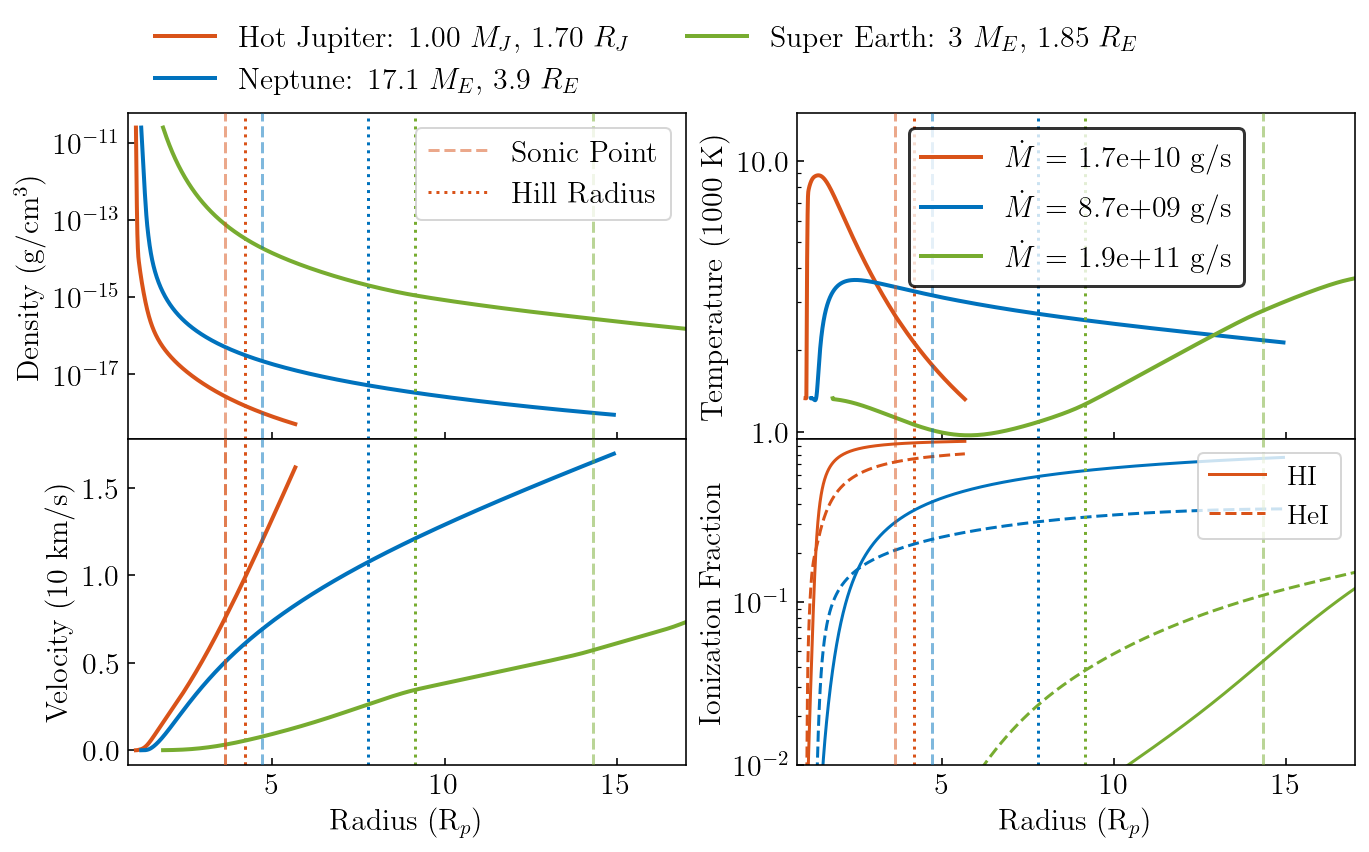

In [3]:
sim = wind_sim()
sim.load_uservars('saves/for_paper/new/small_HJ.csv')
ax = plotter(sim.windsoln,first_plotted=True,
              line_label='Hot Jupiter: %.2f $M_J$, %.2f $R_J$'%(1,1.70),
              line_color='tab:orange',color='#D95319')
sim.load_uservars('saves/for_paper/new/neptune.csv')
plotter(sim.windsoln,ax=ax,line_label='Neptune: 17.1 $M_E$, 3.9 $R_E$',
        line_color='tab:blue',color='#0072BD')
sim.load_uservars('saves/for_paper/new/1.85Re_3.0Me.csv')
plotter(sim.windsoln,ax=ax,line_label='Super Earth: 3 $M_E$, 1.85 $R_E$',
        line_color='tab:green',color='#77AC30')
ax[0,1].set_ylim(top=15)
# ax[0,1].legend()

plt.xlim(0.8,17)

plt.savefig('../Figures/Final/three_planet.pdf',dpi=500,
            facecolor='white')
plt.show()

Thermal balance in that region in detail is necessary to get accurate in that region. Opacity evolution (cite Matthaus). Isotherm value enforced at base, source is PdV cooling.

Be careful to say radius is in Rp OF EACH PLANET

### 2. Energy plot <a id='energyplot'></a>

In [106]:
def energy_plot(windsoln, ax=0, ls='-',tau1=30,eV=25,label='Multi',alpha=0.8, all_terms=False, 
                CII_line_cool=False, CIII_line_cool=False, OII_line_cool=False,OIII_line_cool=False, 
                legend=True,sub_sonic=True):
    try:
        windsoln.soln['heat_ion']
    except KeyError:
        windsoln.add_user_vars()

#     display.display(pl.gcf())
#     display.clear_output(wait=True)
#     pl.clf()
#     if ax==0:
#         fig,ax = pl.subplots()
    if ax==0:
        fig,ax = plt.subplots()
    ncols=1
    fontsize=14
    r = windsoln.soln_norm['r'][1:]
    ax.plot(r, windsoln.soln['heat_ion'][1:], ls,
            alpha=alpha, c='red',label='ionization heating')
    ax.plot(r, -windsoln.soln['cool_lyman'][1:], ls,
            alpha=alpha, c='tab:cyan', label='Lyman-alpha cooling')
    ax.plot(r, -windsoln.soln['cool_PdV'][1:], ls,
            alpha=alpha, c='darkblue',label='PdV cooling')
    if windsoln.bolo_heat_cool != 0:
        ax.plot(r, windsoln.soln['boloheat'][1:], ls=ls,
            alpha=alpha, c='lightcoral',label='bolometric heating')
        ax.plot(r, -windsoln.soln['bolocool'][1:], ls=ls,
            alpha=alpha, c='lightblue',label='bolometric cooling')
    ax.plot(r, windsoln.soln['heat_advect'][1:], ls,
            alpha=alpha, c='maroon', label='advective heating')
    ax.plot(r, -windsoln.soln['heat_advect'][1:], ls,
            alpha=alpha, c='dodgerblue', label='advective cooling')
    
    idx = len(windsoln.E_wl) - np.searchsorted(np.flip(windsoln.E_wl/const.eV),eV)-1
    tau = windsoln.soln['Ncol_HI']*windsoln.sigma_wl[idx][0]+windsoln.soln['Ncol_HeI']*windsoln.sigma_wl[idx][1]
    tau_idx = len(tau) - np.searchsorted(np.flip(tau),1)
    ax.axvline(r[tau_idx],c='k',ls=ls,alpha=0.6)
       
    peak = 10**np.ceil(np.log10(1.1*windsoln.soln['heat_ion'].max()))
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel(r'Energy Rates (erg s$^{-1}$ cm$^{-3}$)')
    ax.set_xlabel(r'Radius ($R_p$)')
    xlo, xhi = windsoln.Rmin-0.02, windsoln.Rmax
    if sub_sonic or not windsoln.integrate_outward:
        xhi = windsoln.R_sp
    ax.set_xlim([xlo, xhi])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    ax.get_xaxis().set_minor_formatter(ticker.ScalarFormatter())
    ax.set_ylim([peak/1e6, peak])
    if legend:
        ax.legend(ncol=ncols,bbox_to_anchor=(1.05,0),loc='lower left',fontsize=fontsize)
    return


Atmosphere Composition
  Species:   HI,        HeI
  Mass frac: 8.00e-01, 2.00e-01


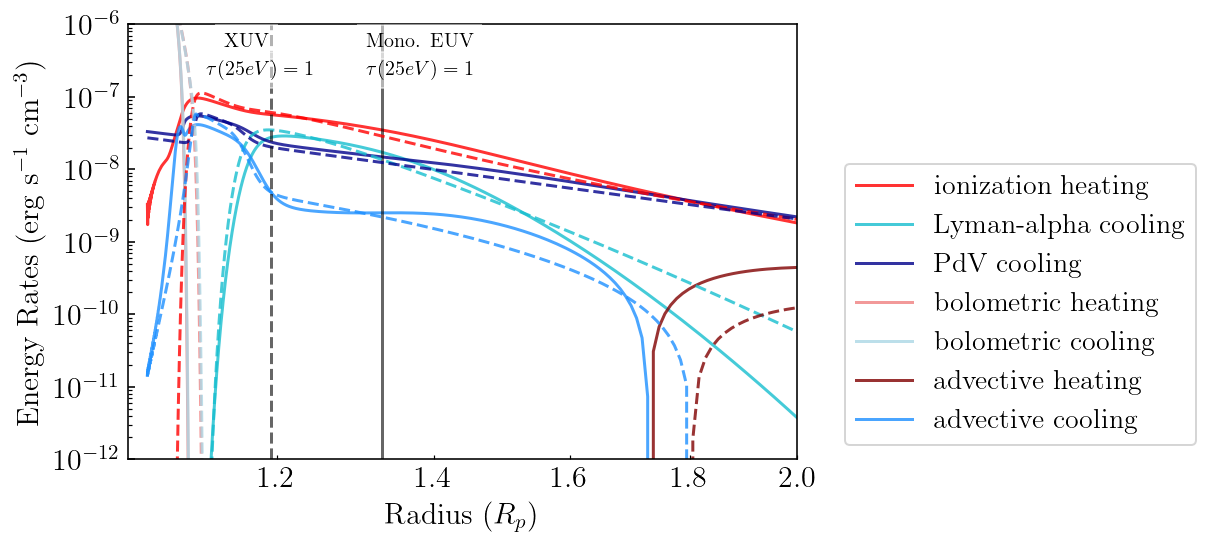

In [115]:
sim = wind_sim()
sim.load_planet('saves/for_paper/new/HD209_13.6-2000eV_H-He.csv')
fig,ax = plt.subplots()
energy_plot(sim.windsoln,ax=ax)
t = plt.text(1.14,4.9e-7,'Mono. EUV',fontsize=10)
t.set_bbox(dict(facecolor='white', alpha=0.5,edgecolor='white'))
t = plt.text(1.12,2e-7,r'$\tau(%.0feV)=1$'%25,fontsize=10)
t.set_bbox(dict(facecolor='white', alpha=0.5,edgecolor='white'))


sim2 = wind_sim()
sim2.load_uservars('saves/for_paper/new/.csv')
energy_plot(sim2.windsoln,ax=ax,ls='--',legend=False)
t = plt.text(1.31,4.9e-7,'XUV',fontsize=10)
t.set_bbox(dict(facecolor='white', alpha=0.5,edgecolor='white'))
t = plt.text(1.31,2e-7,r'$\tau(%.0feV)=1$'%25,fontsize=10)
t.set_bbox(dict(facecolor='white', alpha=0.5,edgecolor='white'))
ax.set_xlim(right=2.0)
plt.savefig('../Figures/Final/energy_plot.pdf',dpi=500,facecolor='white',bbox_inches = "tight")

Maybe say in words: pure-H adding full multifrequency XUV doesn't make that much of a difference (most is from extra flux), so only becomes non-negligible with presence of He and metals.
Ephasize difference in peakiness.

Emphasize normalization of spectrum.

In [3]:
#monofrequency
E = sim.windsoln.E_wl
flux = sim.windsoln.wPhi_wl*sim.windsoln.Ftot*E
print(sum(flux[(E<100*const.eV) & (E>13.6*const.eV)]))

978.9665829777301


In [11]:
# sim.inputs.write_flags(*sim.windsoln.flags_tuple,integrate_out=False)
spec = spectrum()
top = 25
bottom = 27
wl_range = const.hc/(np.array([bottom,top])*const.eV)
for sp in sim.windsoln.species_list:
    spec.add_species(sp)
spec.set_resolved(*wl_range/1e-7) 
spec.set_normalized(*wl_range/1e-7) 
spec.set_window(*wl_range/1e-7,kind='full')
spec.generate(kind='full')
sim.run_wind()

0

### 3. Garcia-Muñoz <a id='garciamunoz'></a>

H3+ - cut off at 163eV and only 70% above 70eV, so total flux is 998

R$_p$ = 1.015, $\rho=7.43 \times 10^{-12}$, T=4000 K


Check flux level in G-M

Check M*

In [36]:
#H3+
# sim.inputs.write_flags(*sim.windsoln.flags_tuple,integrate_out=False)
spec = spectrum()
top = 13.6
bottom = 163
sim.inputs.write_planet_params(*sim.windsoln.planet_tuple[:-2],1014,sim.windsoln.Lstar)
wl_range = const.hc/(np.array([bottom,top])*const.eV)
for sp in sim.windsoln.species_list:
    spec.add_species(sp)
spec.set_resolved(*wl_range/1e-7) 
spec.set_normalized(*wl_range/1e-7) 
spec.set_window(*wl_range/1e-7,kind='full')
spec.generate(kind='full')
print(sim.run_wind())

#70% of flux above 70eV
sim.windsoln.wPhi_wl[0:6] = sim.windsoln.wPhi_wl[0:6]*0.7
sim.windsoln.spectrum_tuple[-3] = sim.windsoln.wPhi_wl
sim.inputs.write_spectrum(*sim.windsoln.spectrum_tuple)
sim.inputs.write_planet_params(*sim.windsoln.planet_tuple[:-2],998,sim.windsoln.Lstar)
print(sim.run_wind())
sim.save_planet('saves/for_paper/new/HD209_H3plus.csv')

0

Atmosphere Composition
  Species:   HI,        HeI
  Mass frac: 8.00e-01, 2.00e-01
Ramping Mstar from 1.988e+33 to 2.287e+33 AND semimajor from 7.480e+11 to 7.480e+11 AND Lstar from 3.828e+33 to 3.828e+33.
  semimajor already done.
  Lstar already done.
  Final:  Mstar:2.286678e+33, M_delta:0.003785                                               


0

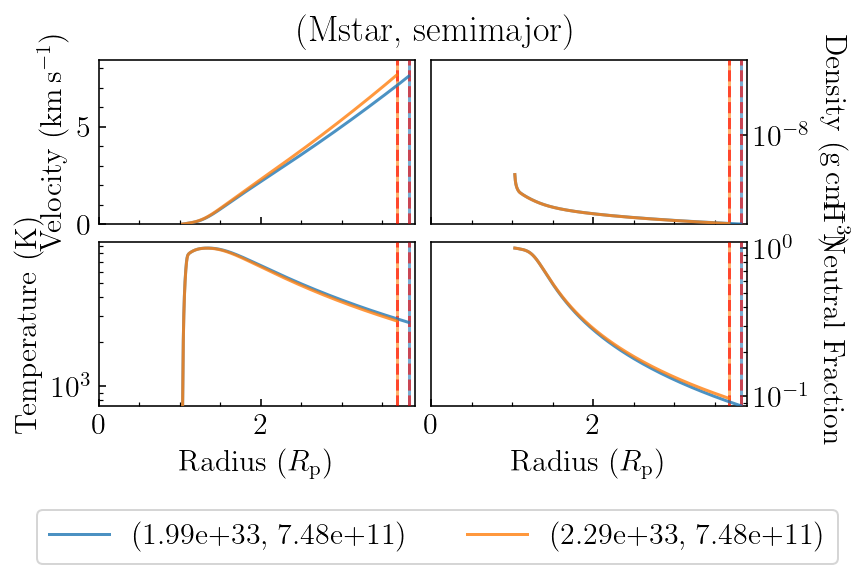

In [52]:
sim.load_planet('saves/for_paper/new/HD209_garcia-munoz_BCs.csv')
rr = system(*sim.windsoln.planet_tuple[:2],
                1.15*const.Msun,*sim.windsoln.planet_tuple[3:])
sim.ramp_star(rr,converge=False,expedite=True)

In [55]:
sim.ramp_spectrum(1000,[13.6,40])

Goal: [ 0.6 91.2] nm
Ramped spectrum wavelength range, now normalizing spectrum. 
Ramping Ftot from 1.074e+03 to 2.435e+03.                                                                    
  Final:  Ftot:2.434918e+03, delta:0.2926                                                                      


0

In [56]:
sim.converge_Ncol_sp()
sim.converge_Rmax()

Successfully converged Rmax to 6.072229 (Ncol also converged).                                                                                                                           

0

In [57]:
sim.save_planet('saves/for_paper/new/HD209_garcia-munoz_BCs_hiflux.csv')

Saving saves/for_paper/new/HD209_garcia-munoz_BCs_hiflux.csv


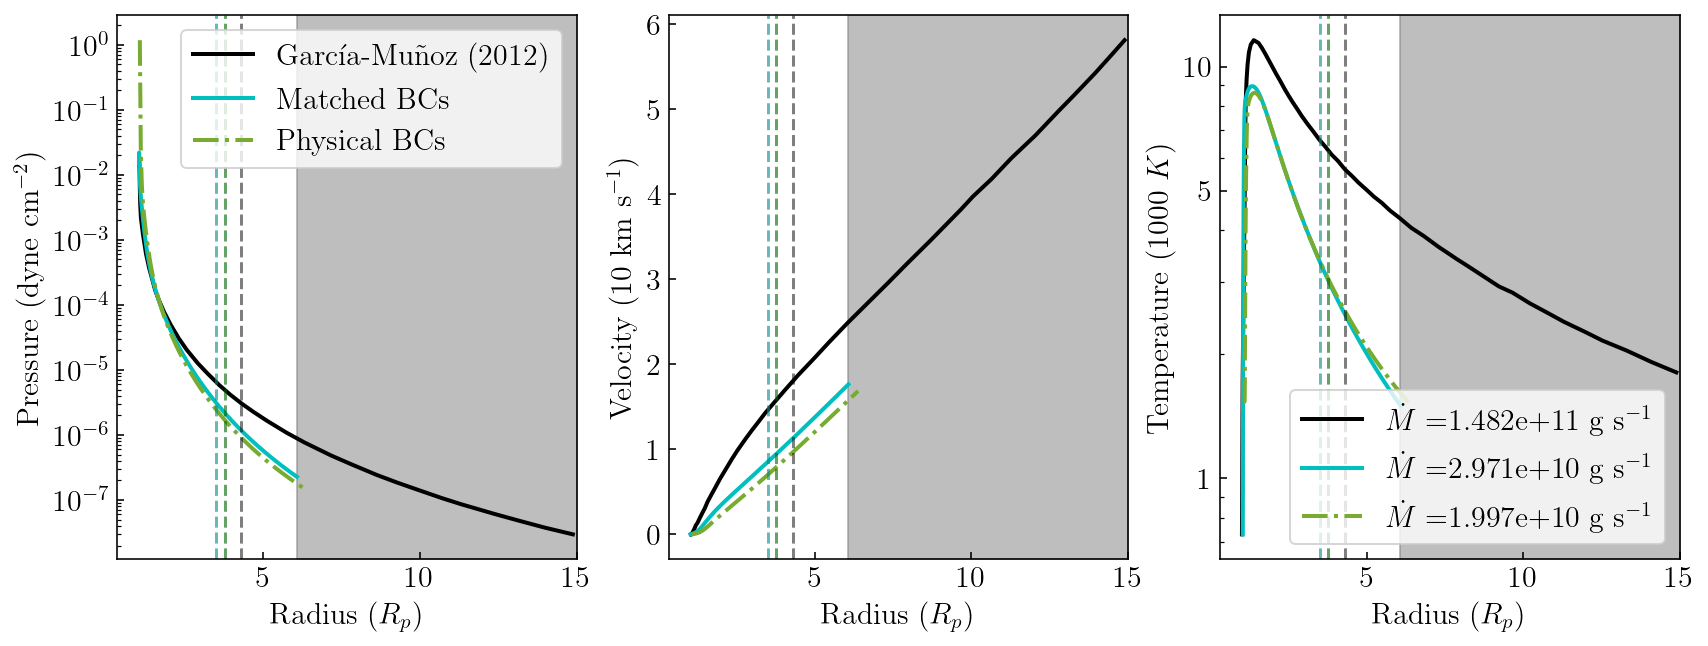

In [59]:
sim  = wind_sim()
# sim.load_uservars('saves/for_paper/new/HD209_13.6-2000eV_H-He.csv')
sim.load_uservars('saves/for_paper/new/HD209_garcia-munoz_BCs_hiflux.csv')
sim2 = wind_sim()
sim2.load_uservars('saves/for_paper/new/HD209_13.6-2000eV_H-He.csv')

r = sim.windsoln.soln_norm['r']
r2 = sim2.windsoln.soln_norm['r']

r_vel,vel = np.genfromtxt('Data_for_Comparisons/munoz_velocity_tf.csv',delimiter=',',skip_header=1).T
r_temp,temp = np.genfromtxt('Data_for_Comparisons/munoz_temperature_tf.csv',delimiter=',',skip_header=1).T
r_dens,dens = np.genfromtxt('Data_for_Comparisons/munoz_pressure_tf.csv',delimiter=',',skip_header=1).T

r = sim.windsoln.soln_norm['r']
fig,ax = plt.subplots(1,3,figsize=(14,5))
ax[2].plot(r_temp,temp/1000,lw=2,c='k',label=r'$\dot{M}=$%.3e g s$^{-1}$'%1.482e11)
ax[2].plot(r,sim.windsoln.soln['T']/1000,c='c',lw=2,
           label=r'$\dot{M}=$%.3e g s$^{-1}$'%sim.windsoln.Mdot)
ax[2].plot(r2,sim2.windsoln.soln['T']/1000,c='#77AC30',lw=2,ls='-.',
          label=r'$\dot{M}=$%.3e g s$^{-1}$'%sim2.windsoln.Mdot)
ax[2].set_yscale('log')
ax[2].legend(loc='lower right')
lims = np.copy(ax[2].get_ylim())
ax[2].fill_betweenx(lims,sim.windsoln.r_cori,15,
                   color='tab:gray',alpha=0.5)
ax[2].set_ylim(lims)
# ax[2].get_yaxis().set_minor_formatter(ticker.ScalarFormatter())
ax[2].get_yaxis().set_major_formatter(ticker.ScalarFormatter())
ax[2].set_yticks([1,5,10],label=['1','5','10'])
ax[2].set_ylabel('Temperature (1000 $K$)')


ax[0].plot(r_dens,dens,lw=2,c='k',label=r'García-Mu$\rm{\tilde{n}}$oz (2012)')
ax[0].plot(r,sim.windsoln.soln['P'],c='c',lw=2,label='Matched BCs')
ax[0].plot(r2,sim2.windsoln.soln['P'],c='#77AC30',lw=2,ls='-.',label='Physical BCs')
ax[0].set_yscale('log')
lims = np.copy(ax[0].get_ylim())
ax[0].fill_betweenx(lims,sim.windsoln.r_cori,15,
                   color='tab:gray',alpha=0.5)
ax[0].set_ylim(lims)
ax[0].set_ylabel('Pressure (dyne cm$^{-2}$)')
ax[0].legend()

ax[1].plot(r_vel,vel/1e6,lw=2,c='k')
ax[1].plot(r,sim.windsoln.soln['v']/1e6,c='c',lw=2)
ax[1].plot(r2,sim2.windsoln.soln['v']/1e6,c='#77AC30',lw=2,ls='-.')
# ax[1].set_yscale('log')
lims = np.copy(ax[1].get_ylim())
ax[1].fill_betweenx(lims,sim.windsoln.r_cori,15,
                   color='tab:gray',alpha=0.5)
ax[1].set_ylim(lims)
ax[1].set_ylabel('Velocity (10 km s$^{-1}$)')
for i in range(3):
    ax[i].set_xlim(right=15)
#     ax[i].set_xticks([1,2,4,10,100],labels=['1','2','4','10','100'])
    ax[i].set_xlabel('Radius ($R_p$)')
    ax[i].axvline(4.3,c='k',ls='--',alpha=0.5)
    ax[i].axvline(sim.windsoln.R_sp,c='darkcyan',ls='--',alpha=0.6)
    ax[i].axvline(sim2.windsoln.R_sp,c='darkgreen',ls='--',alpha=0.6)
#     ax[i].fill_betweenx((0,1e8),sim.windsoln.r_cori,sim.windsoln.Rmax,
#                        color='tab:gray',alpha=0.5)
# plt.savefig('../Figures/Final/garcia_munoz_compare_tf.pdf',dpi=500,facecolor='white',
#             bbox_inches='tight')
plt.show()

##### Pwinds

daria kubyshkina

In [57]:
from p_winds import tools, parker, hydrogen, helium, transit, lines

In [58]:
# HD 209458 b planetary parameters, measured
R_pl = 1.39  # Planetary radius in Jupiter radii
M_pl = 0.73  # Planetary mass in Jupiter masses
impact_parameter = 0.499  # Transit impact parameter

# A few assumptions about the planet's atmosphere
m_dot = 10 ** 10.27  # Total atmospheric escape rate in g / s
T_0 = 9100  # Wind temperature in K
h_fraction = 0.90  # H number fraction
he_fraction = 1 - h_fraction  # He number fraction
he_h_fraction = he_fraction / h_fraction
mean_f_ion = 0.0  # Mean ionization fraction (will be self-consistently calculated later)
mu_0 = (1 + 4 * he_h_fraction) / (1 + he_h_fraction + mean_f_ion)
# mu_0 is the constant mean molecular weight (assumed for now, will be updated later)

In [63]:
units = {'wavelength': u.angstrom, 'flux': u.erg / u.s / u.cm ** 2 / u.angstrom}
spectrum = tools.make_spectrum_from_file('../../data/solar_spectrum_scaled_lambda.dat',units)
plt.loglog(spectrum['wavelength'], spectrum['flux_lambda'])
plt.ylim(1e-5, 1e4)
plt.xlabel(r'Wavelength (${\rm \AA}$)')
plt.ylabel(r'Flux density (erg s$^{-1}$ cm$^{-2}$ ${\rm \AA}^{-1}$)')
plt.show()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/m/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/v1/z_ltj1m538g1c2drkd2xfck40000gn/T/ipykernel_87619/2868463736.py", line 2, in <cell line: 2>
    spectrum = tools.make_spectrum_from_file('../../data/solar_spectrum_scaled_lambda.dat',units)
  File "/Users/m/opt/anaconda3/lib/python3.9/site-packages/p_winds/tools.py", line 385, in make_spectrum_from_file
    spectrum_table = np.loadtxt(path + filename, usecols=(0, 1),
  File "/Users/m/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/npyio.py", line 1356, in loadtxt
  File "/Users/m/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/npyio.py", line 975, in _read
    """Chop off comments, strip, and split at delimiter."""
  File "/Users/m/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/_datasource.py", line 193, in open
    return ds.open(path, mode, encod

In [60]:
initial_f_ion = 0.0
r = np.logspace(0, np.log10(20), 100)  # Radial distance profile in unit of planetary radii

f_r, mu_bar,rates = hydrogen.ion_fraction(r, R_pl, T_0, h_fraction,
                            m_dot, M_pl, mu_0,
                            spectrum_at_planet=spectrum, exact_phi=True,
                            initial_f_ion=initial_f_ion, relax_solution=True,
                            return_mu=True, return_rates=True)

TypeError: 'type' object is not subscriptable

### 4. Multifrequency <a id='multifrequency'></a>

In [ ]:
#Removing He from solution:
sim = wind_sim()
sim.load_planet('saves/for_paper/new/HD209_13.6-2000eV_H-He.csv')
sim.remove_metals(['HeI'])
sim.polish_bcs()
# sim.save_planet('saves/')

In [4]:
#ramping to EUV only
sim.load_planet('saves/for_paper/new/HD209_13.6-2000eV_H.csv')
sim.ramp_spectrum(450,[13.6,40],[13.6,100])
sim.polish_bcs()

Atmosphere Composition
  Species:   HI
  Mass frac: 1.00e+00
Goal: [12.39842547 91.16489319] nm
Ramped spectrum wavelength range, now normalizing spectrum. 
Ramping Ftot from 1.096e+03 to 1.010e+03.                                                                   
  Final:  Ftot:1.010286e+03, delta:0.01995                                                                      
Polishing up boundary conditions...
Successfully converged Rmax to 6.928219 (Ncol also converged).                                                                            

0

*****Monofrequency (20eV), single species (H) Mdot = 6.40e+09 g/s ******
Atmosphere Composition
  Species:   HI
  Mass frac: 1.00e+00
*****Monofrequency (20eV), H, updated BCs Mdot = 3.00e+10 g/s ******
*****EUV Multifrequency (13.6-100eV), single species (H) Mdot = 4.28e+10 g/s ******
*****XUV Multifrequency (13.6-2000eV), single species (H) Mdot = 4.18e+10 g/s ******


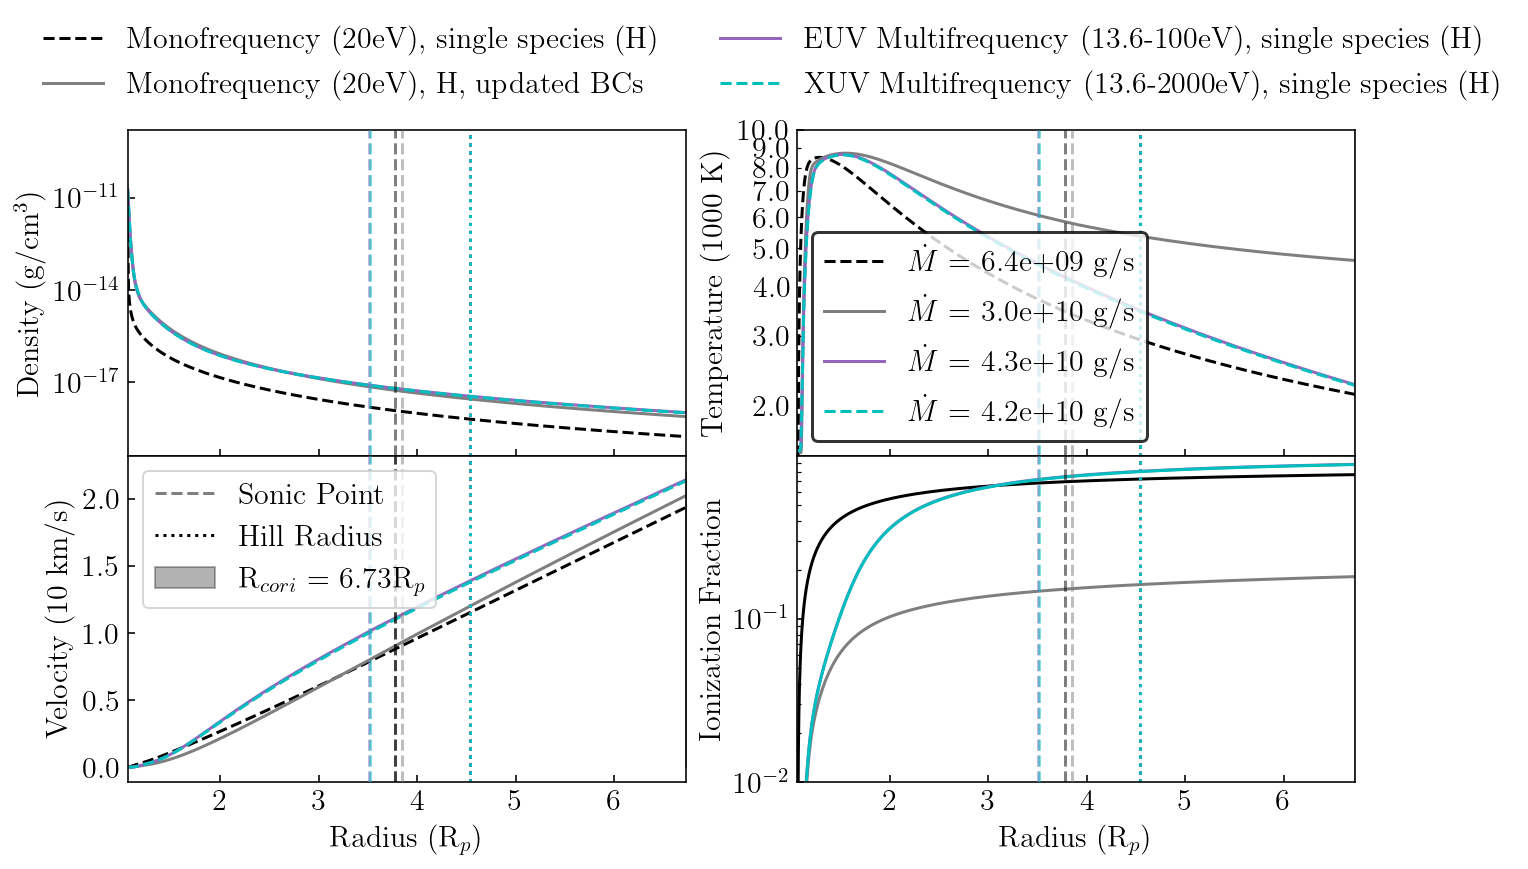

In [11]:
label_arr = [-0.2,1.4,2]
sim0 = wind_sim()
sim0.load_uservars('saves/Old/my_saves/MC09_lo_mono.csv')
ax = quick_plot(sim0.windsoln,first_plotted=True,line_style='--',line_color='k',
              ion_label=False,
        line_label='Monofrequency (20eV), single species (H)',
              label_dim=label_arr)
sim1 = wind_sim()
sim1.load_planet('saves/HD209458b/HD209458b_mono20eV_H.csv')
quick_plot(sim1.windsoln,ax=ax,line_color='tab:gray',ion_label=False,
        line_label='Monofrequency (20eV), H, updated BCs',
         label_dim=label_arr)
sim2 = wind_sim()
sim2.load_uservars('saves/for_paper/new/HD209_13.6-100eV_H.csv') #matching Ncol no diff (4.0 vs. 4.1 self consistent)
quick_plot(sim2.windsoln,ax=ax,line_color='tab:purple',ion_label=False,
        line_label='EUV Multifrequency (13.6-100eV), single species (H)',
         label_dim=label_arr)
sim3 = wind_sim()
sim3.load_uservars('saves/for_paper/new/HD209_13.6-2000eV_H.csv') 
quick_plot(sim3.windsoln,ax=ax,line_color='c',line_style='--',ion_label=False,
        line_label='XUV Multifrequency (13.6-2000eV), single species (H)',
         label_dim=label_arr)
ax[0,1].set_ylim(top=10)
# sim3 = wind_sim()
# sim3.load_planet('saves/HD209458b/HD209458b_13.6-100_')
# FourPlot(sim3.windsoln,ax=ax,line_color='m',
#         line_label='EUV Multifrequency (13.6-100eV), multispecies (H,He,C,N,O,Ne,Mg)')
# sim4 = wind_sim()
# sim4.load_planet('saves/HD209458b/HD209458b_13.6-2000_')
# FourPlot(sim4.windsoln,ax=ax,line_color='c',
#         line_label='XUV Multifrequency (13.6-2000eV), multispecies (H,He,C,N,O,Ne,Mg)')
# sim5 = wind_sim()
# sim5.load_planet('saves/HD209458b/HD209458b_H3plus_')
# FourPlot(sim5.windsoln,ax=ax,line_color='k',
#         line_label='XUV Pseudo-H3+ Cooled (13.6-165eV), multispecies (H,He,C,N,O,Ne,Mg)')
# ax[0,0].axvline(sim.windsoln.rHill/sim.windsoln.Rp,ls=':')
plt.xlim(right = np.min([sim0.windsoln.r_cori,sim1.windsoln.r_cori,
                         sim2.windsoln.r_cori]))
plt.savefig('../Figures/final_multi_compare.pdf',dpi=500,facecolor='white',
           bbox_inches='tight')

plt.show()

### 5. Mass-Loss as a Function of Semimajor Axis <a id='semimajor'></a>

Also check what is forcing bolometric heating/cooling to turn back on

In [25]:
a = 0.15
print("%.12e"%(a*const.au))
F = 1095*(0.05/a)**2
F_opt = sim.windsoln.Lstar/(4*np.pi*(a*const.au)**2)
print(F)
Kappa_opt=4e-3
Kappa_IR=1e-2
T_skin = (F_opt*(Kappa_opt+Kappa_IR/4)/(2*const.sig_SB*Kappa_IR))**0.25
print(T_skin/1e4)

# min_H = 0.001*sim.windsoln.Rp
# T_min = min_H*2.3*const.mH*const.G*sim.windsoln.Mp / (const.kB*sim.windsoln.Rp**2)
# print(T_min)
# a_min = np.sqrt(sim.windsoln.Lstar/4*np.pi/(T_min**4 * (2*const.sig_SB*Kappa_IR) / (Kappa_opt+Kappa_IR/4) ))/const.au
# print(a_min)
# print(sim.base_bcs())
# temp = system(1.33e+30,10000000000.0,1.988416e+33,a*const.au,
#                F,1.00*const.Lsun)
# result = sim.ramp_star(system=temp,converge=True,integrate_out=False)
# sim.polish_bcs()
# sim.ramp_var("Ftot",F,converge_bcs=False)
# print(result)

2.244000000000e+12
121.66666666666669
0.07673516442470676


Maybe ramp by hand because need a way to enforce the bolometric heating and cooling to stay off. Probably what this means is that I should chose a different planet. but could also be a good place to mention the high gravity issues.

Atmosphere Composition
  Species:   HI,        HeI
  Mass frac: 8.00e-01, 2.00e-01
---
 30.41666666666667
Ramping Mstar from 1.988e+33 to 1.988e+33 AND semimajor from 2.992e+12 to 4.488e+12 AND Lstar from 3.828e+33 to 3.828e+33.
  Mstar already done.
  Lstar already done.
  Trying: semimajor:3.051840e+12, a_delta:0.02                                               

KeyboardInterrupt: 

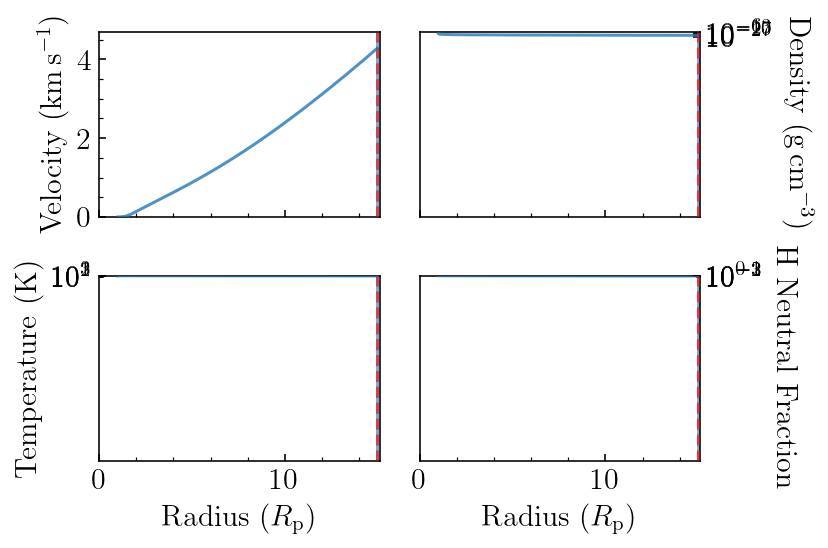

In [5]:
sim = wind_sim()
sim.load_planet('saves/for_paper/new/0.20au.csv')

for a in np.arange(0.3,0.9,0.1):
    F = 1095*(0.05/a)**2
    print('---\n',F)
    temp = system(1.33e+30,10000000000.0,1.988416e+33,a*const.au,
                   F,1.00*const.Lsun)
    sim.inputs.write_flags(1,1,0,1)
    if sim.ramp_star(system=temp,converge=True,integrate_out=False) == 0:
        sim.inputs.write_flags(1,1,0,1)
        sim.polish_bcs()
        sim.inputs.write_flags(1,1,0,1)
        sim.ramp_var("Ftot",F,converge_bcs=False)
        print(f'Succesfully ramped to {a} au.')
        sim.inputs.write_flags(1,1,0,1)
        result = sim.polish_bcs()
        if (result == 0) or (result==5):
            sim.save_planet('saves/for_paper/new/%.2fau.csv'%a,overwrite=True)  

    else:
        break

3041.666666667


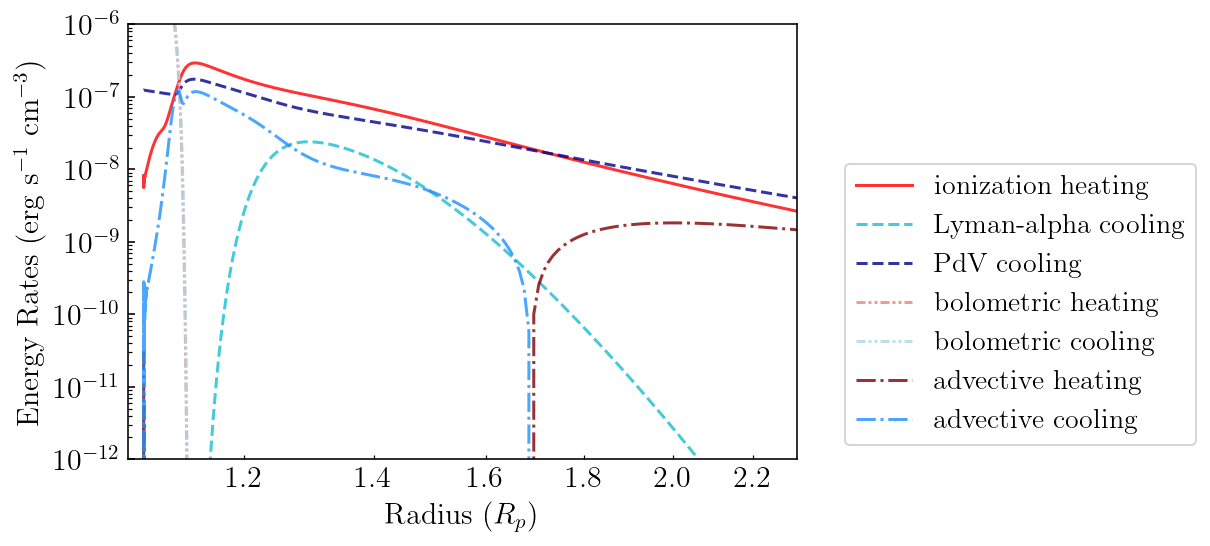

***** 222.70Mearth_15.68Rearth_3041F_scaled-solar: Mdot = 8.00e+10 g/s *****


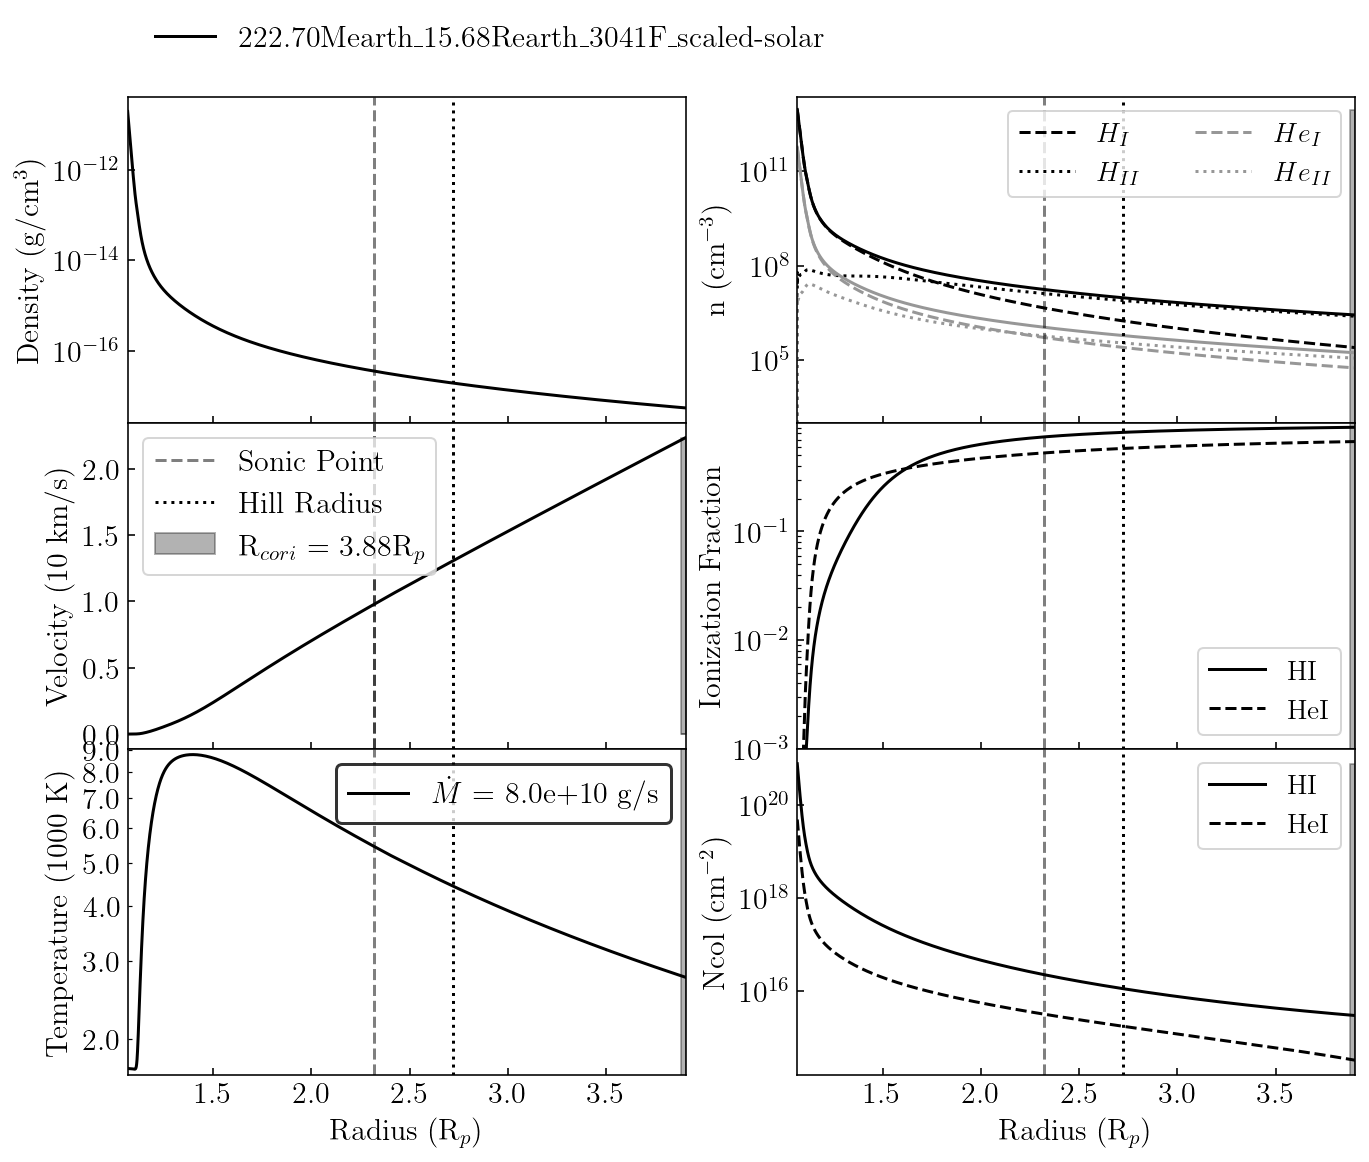

760.4166666667


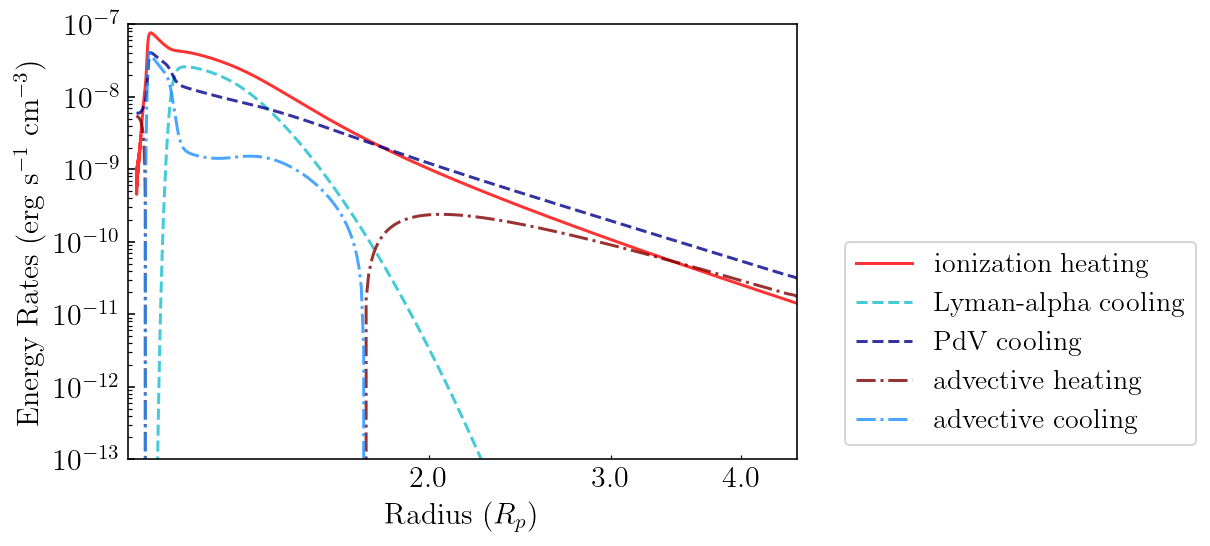

***** 222.70Mearth_15.68Rearth_760F_scaled-solar: Mdot = 1.07e+10 g/s *****


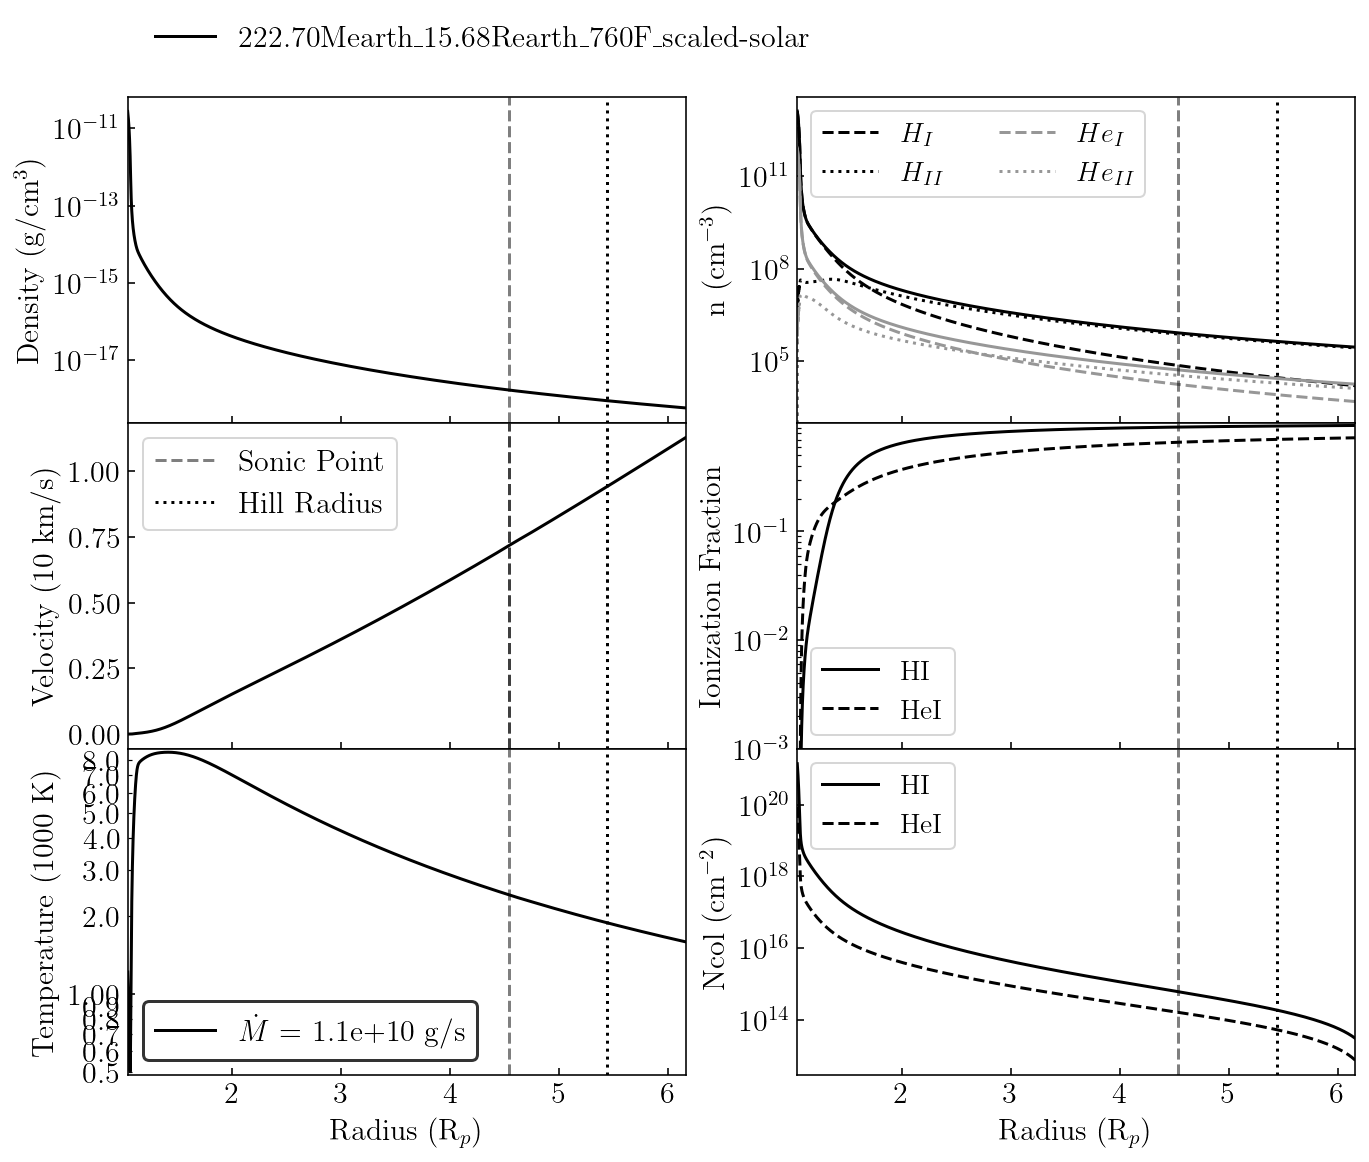

273.75


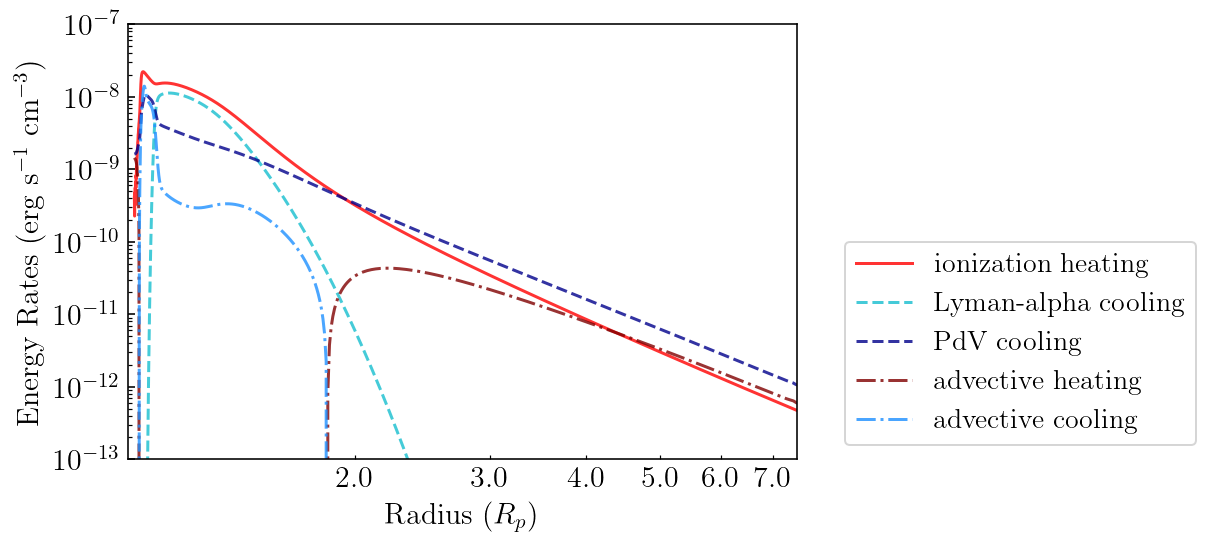

***** 222.70Mearth_15.68Rearth_273F_scaled-solar: Mdot = 2.73e+09 g/s *****


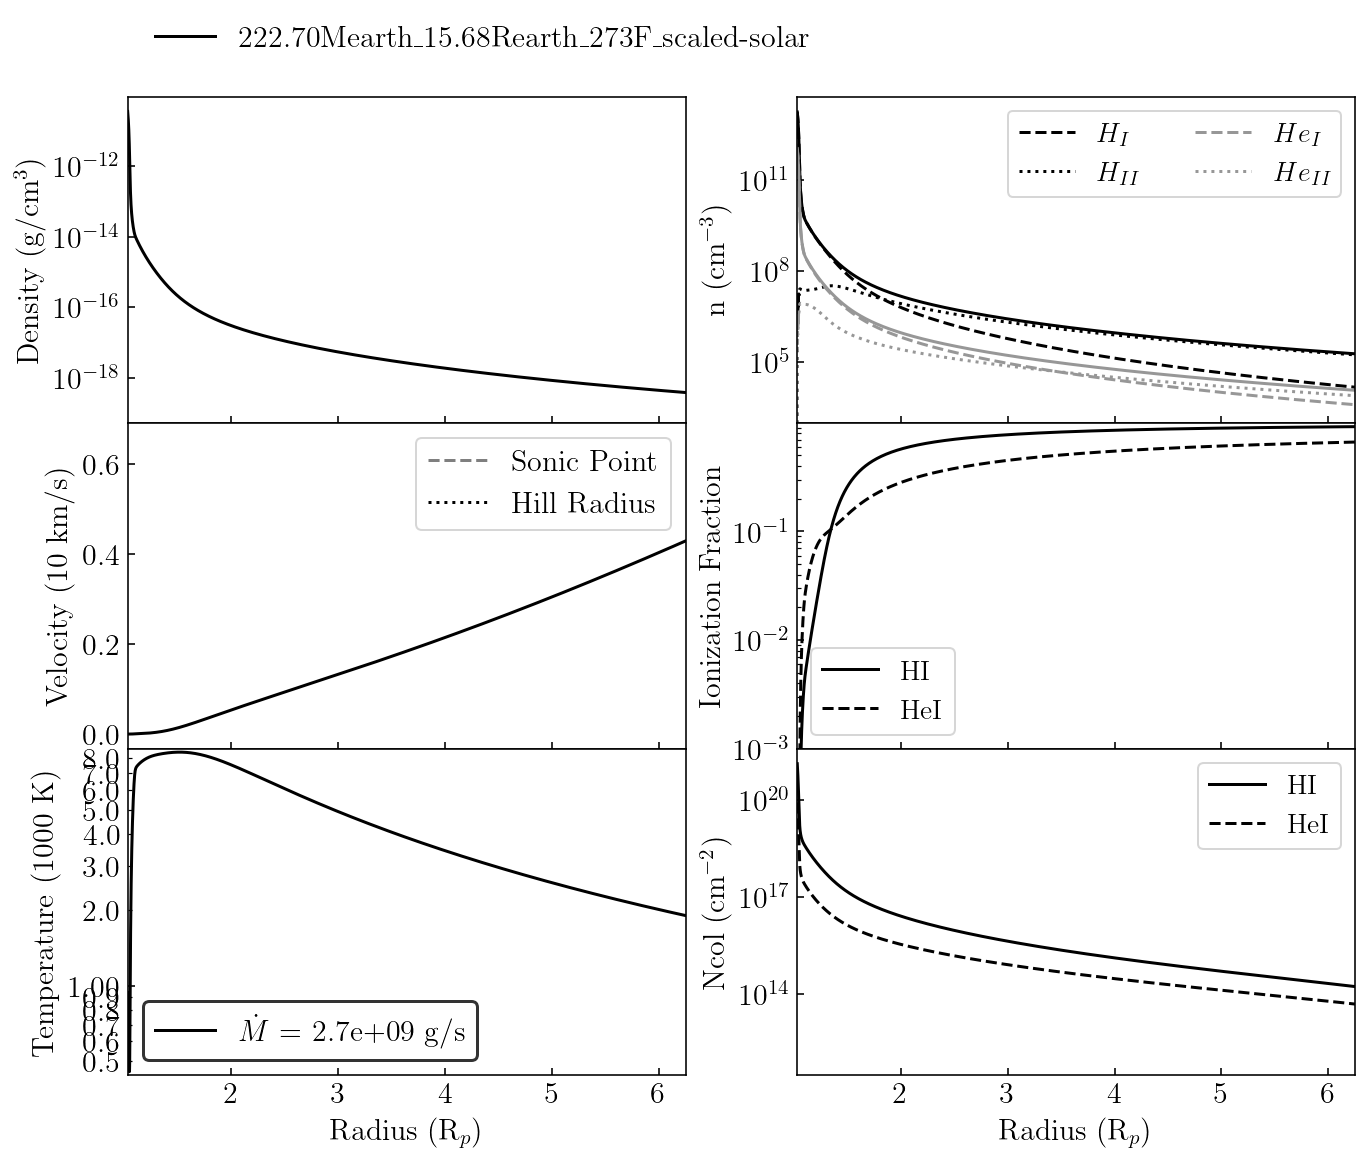

68.4375


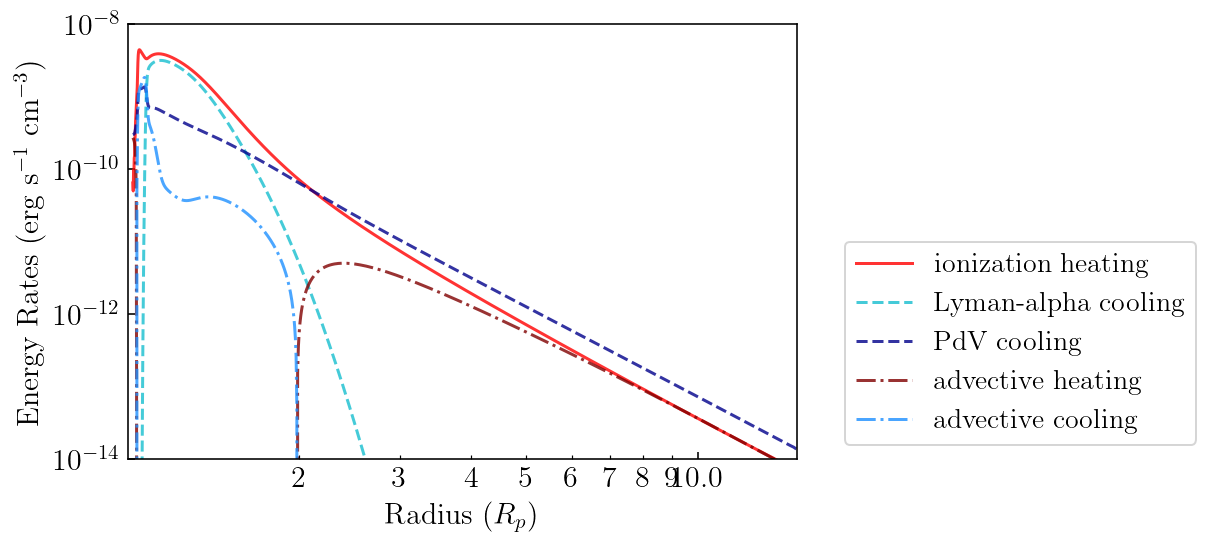

***** 222.70Mearth_15.68Rearth_68F_scaled-solar: Mdot = 4.86e+08 g/s *****


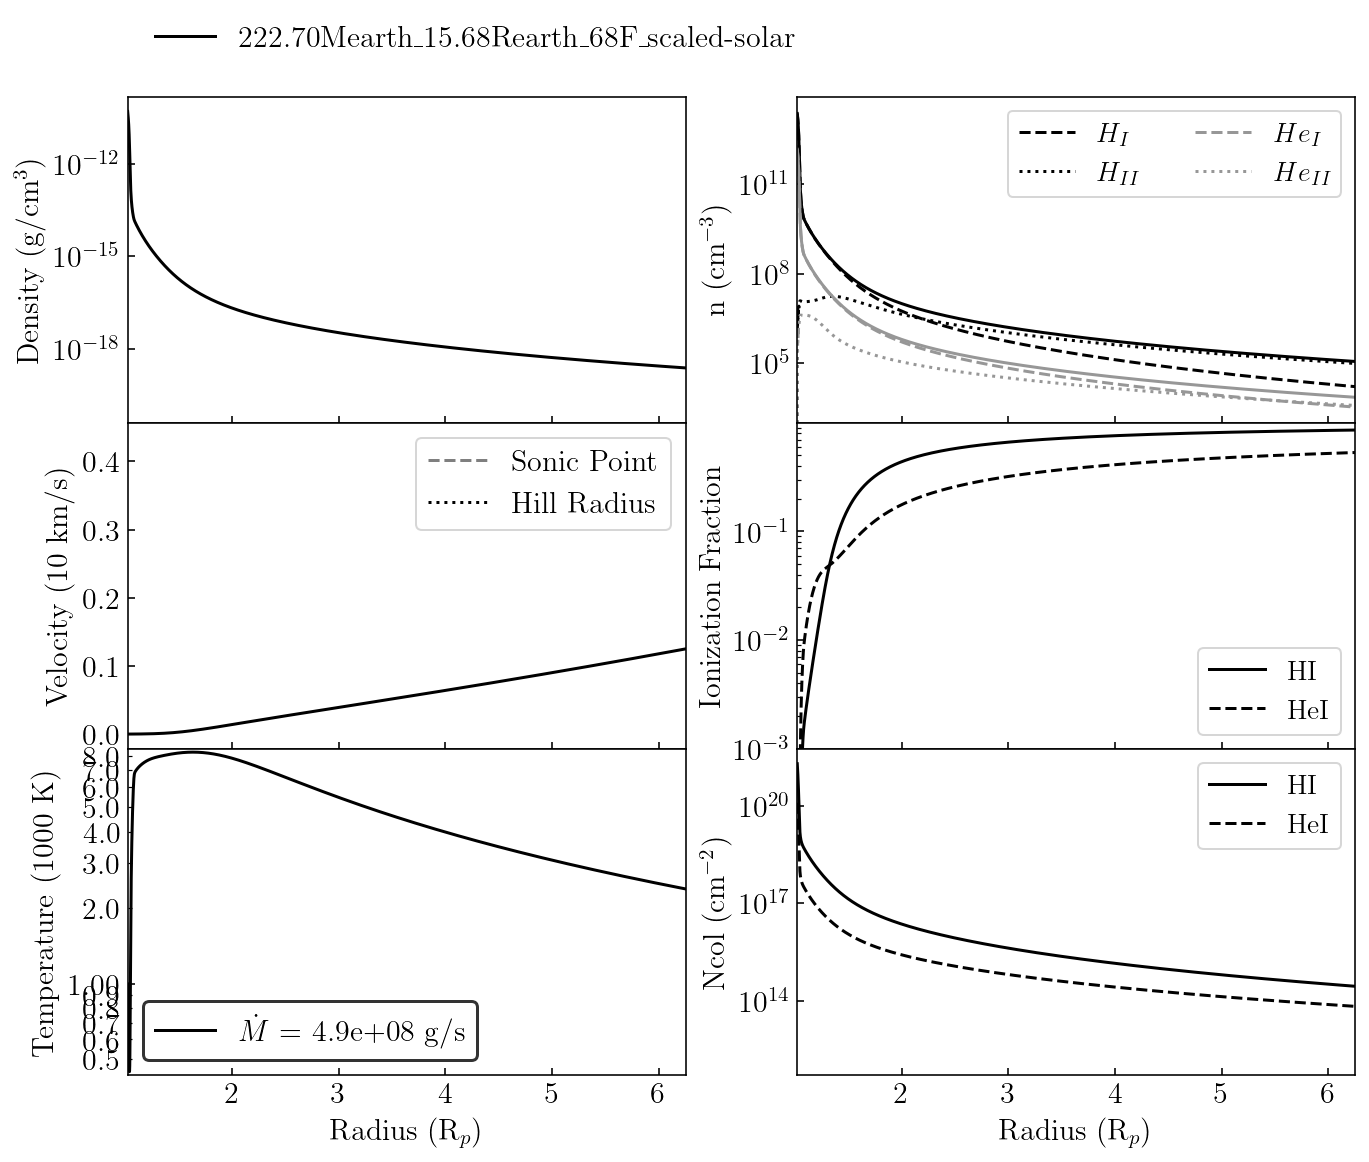

30.41666666667


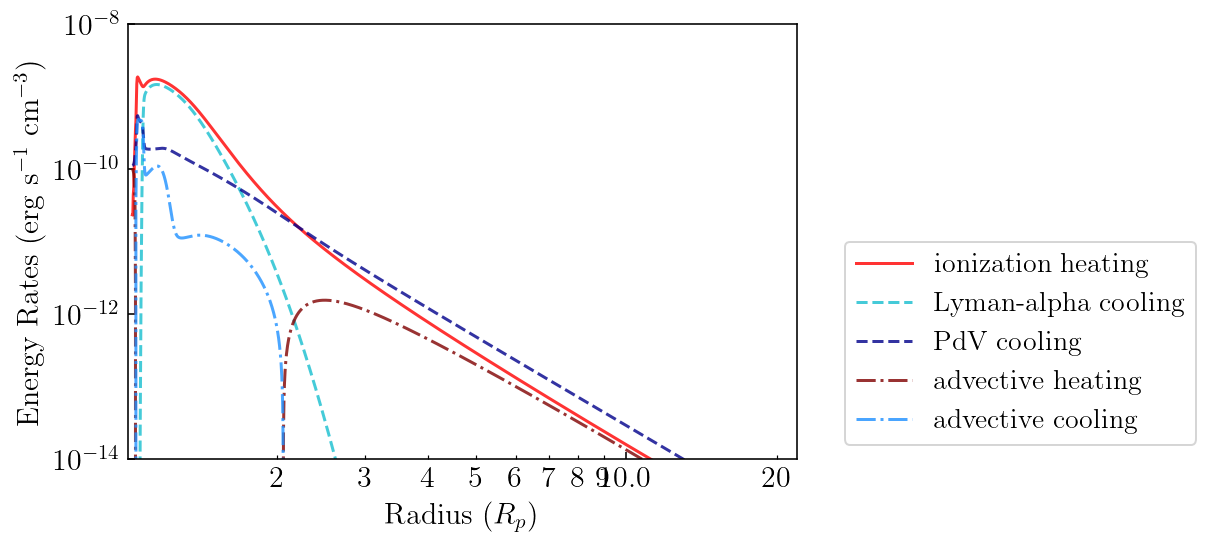

***** 222.70Mearth_15.68Rearth_30F_scaled-solar: Mdot = 1.82e+08 g/s *****


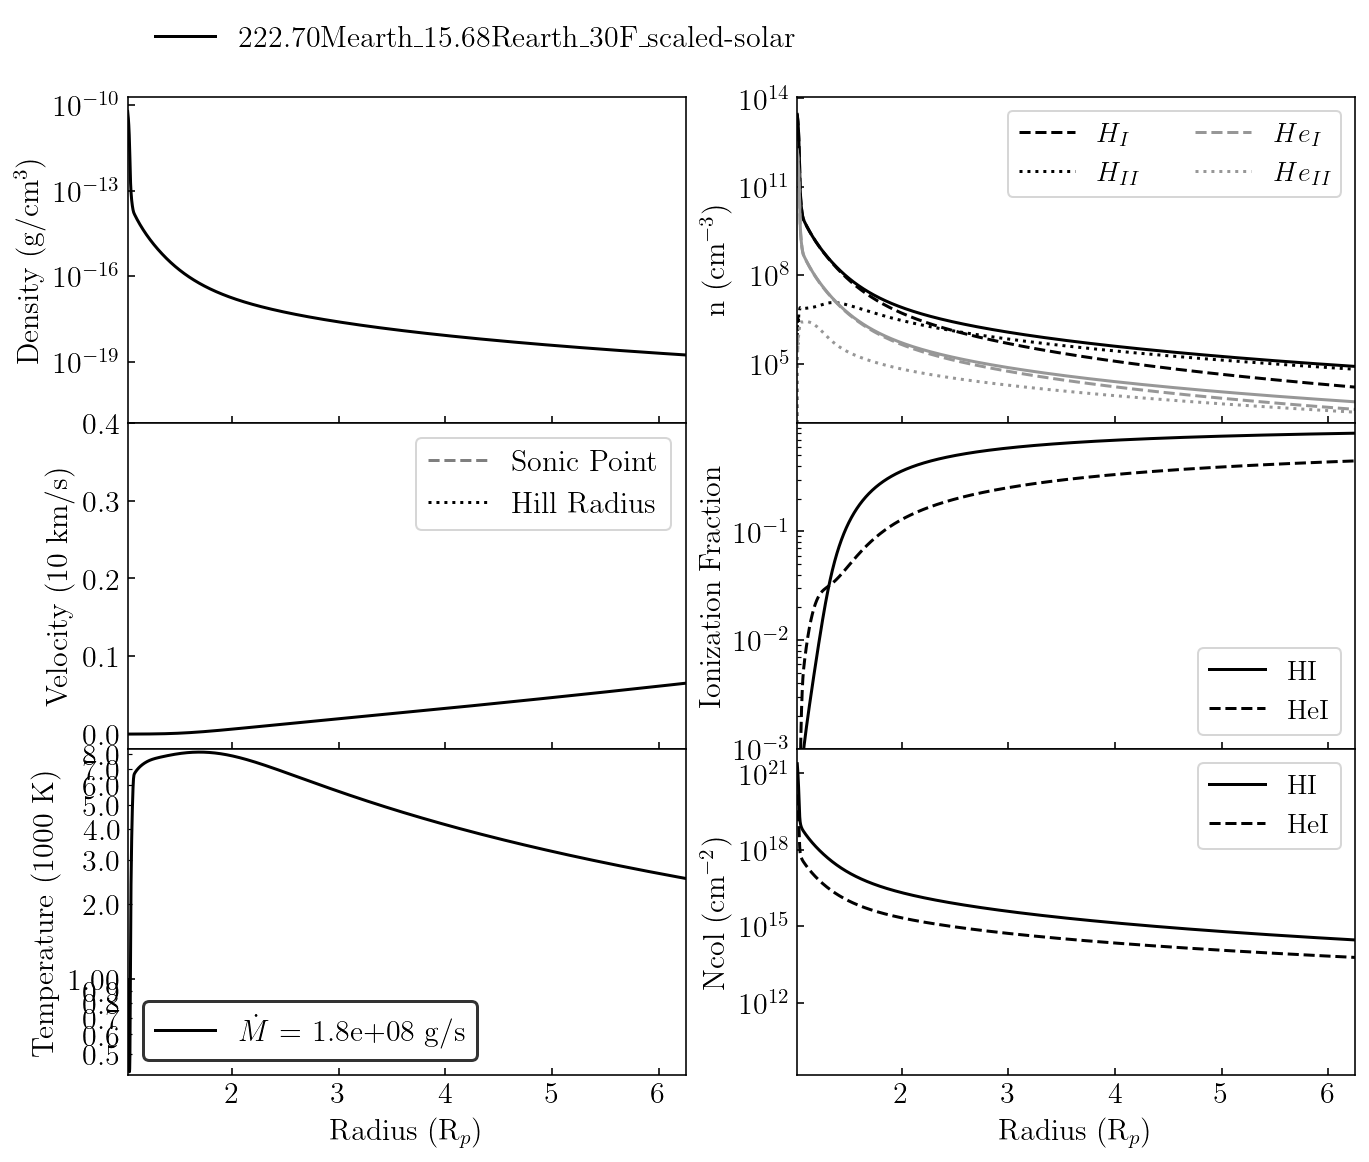

17.109375


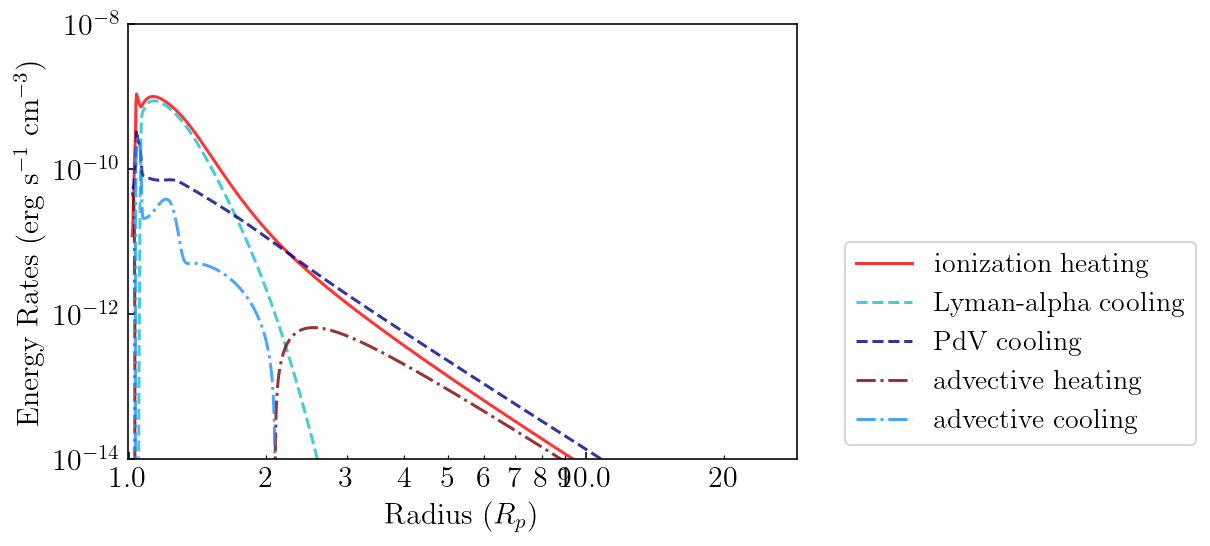

***** 222.70Mearth_15.68Rearth_17F_scaled-solar: Mdot = 8.40e+07 g/s *****


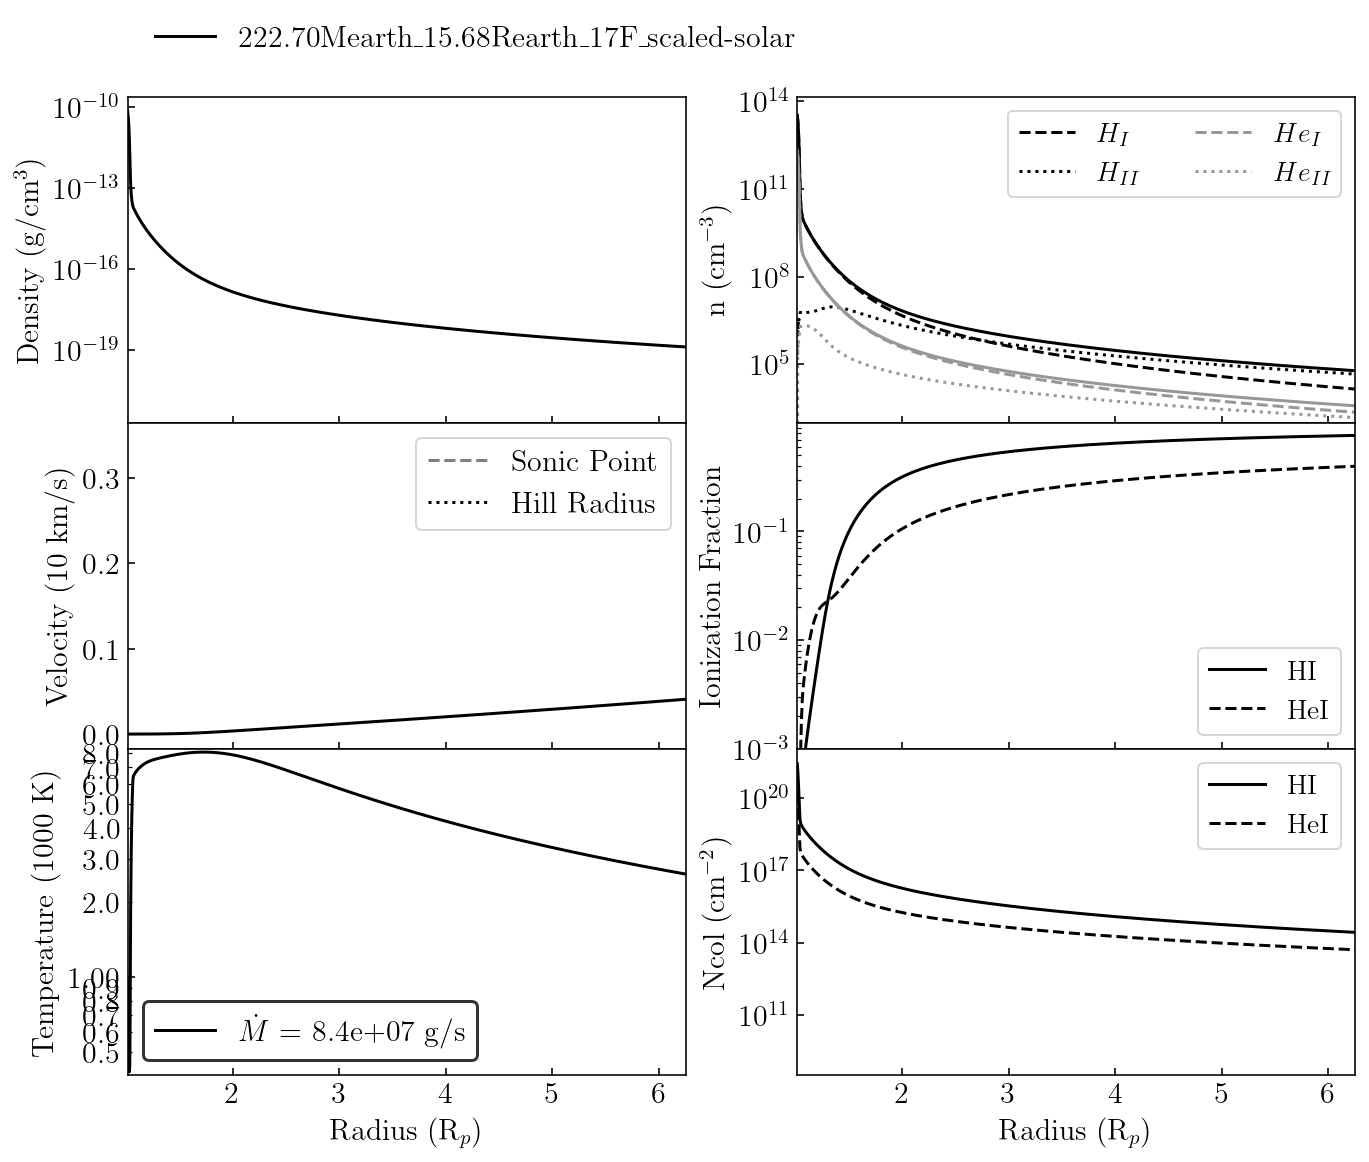

10.95


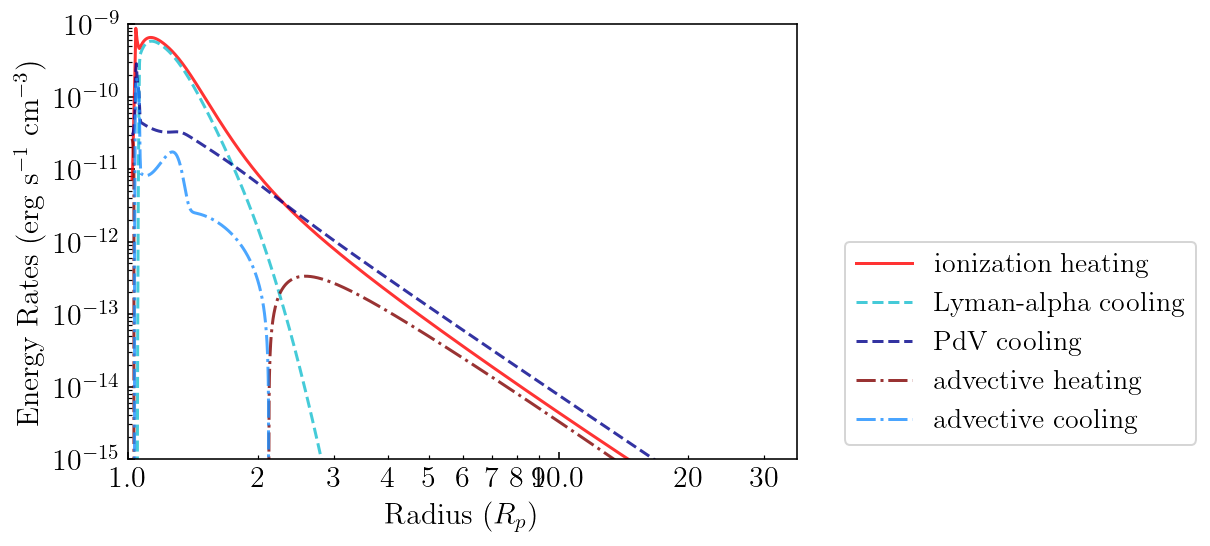

***** 222.70Mearth_15.68Rearth_10F_scaled-solar: Mdot = 4.62e+07 g/s *****


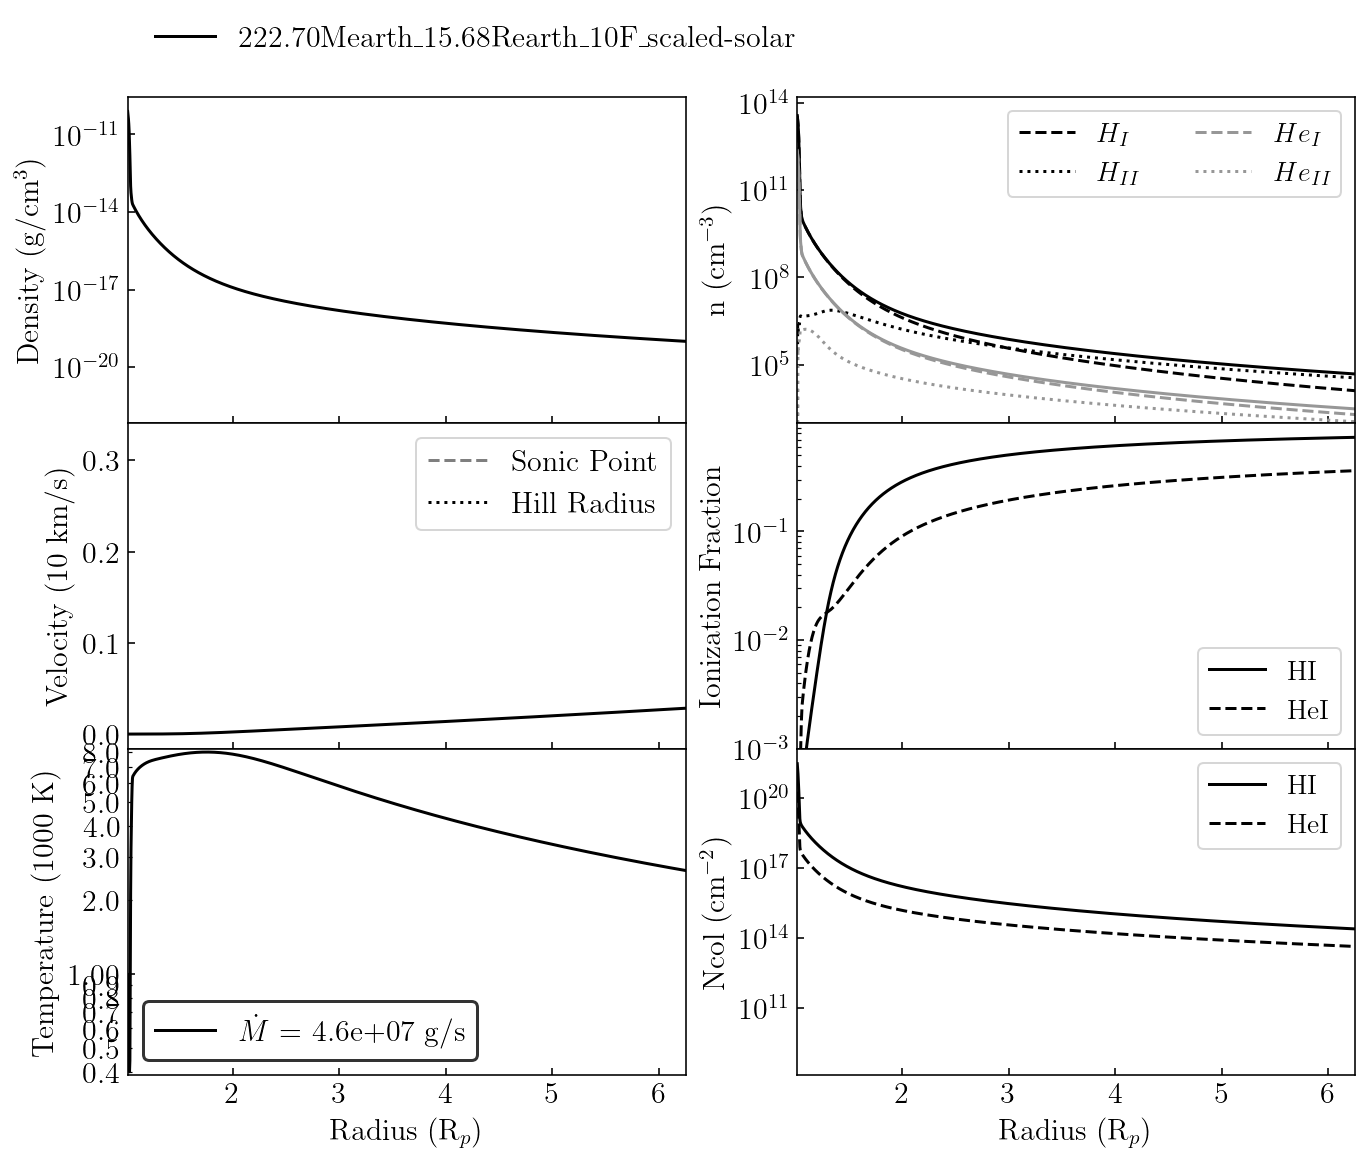

7.604166666667


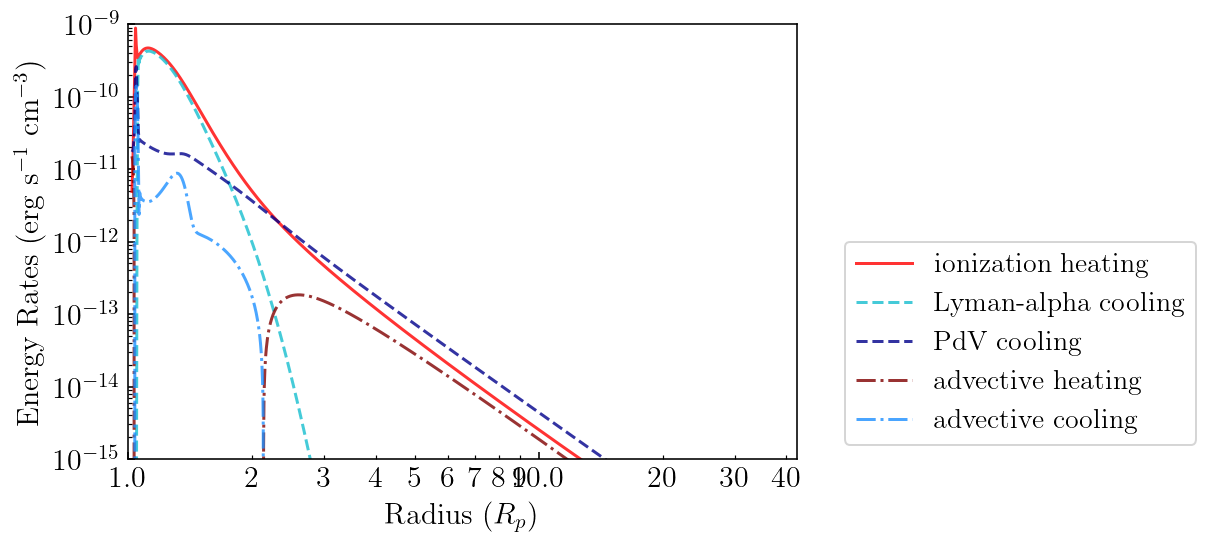

***** 222.70Mearth_15.68Rearth_7F_scaled-solar: Mdot = 2.65e+07 g/s *****


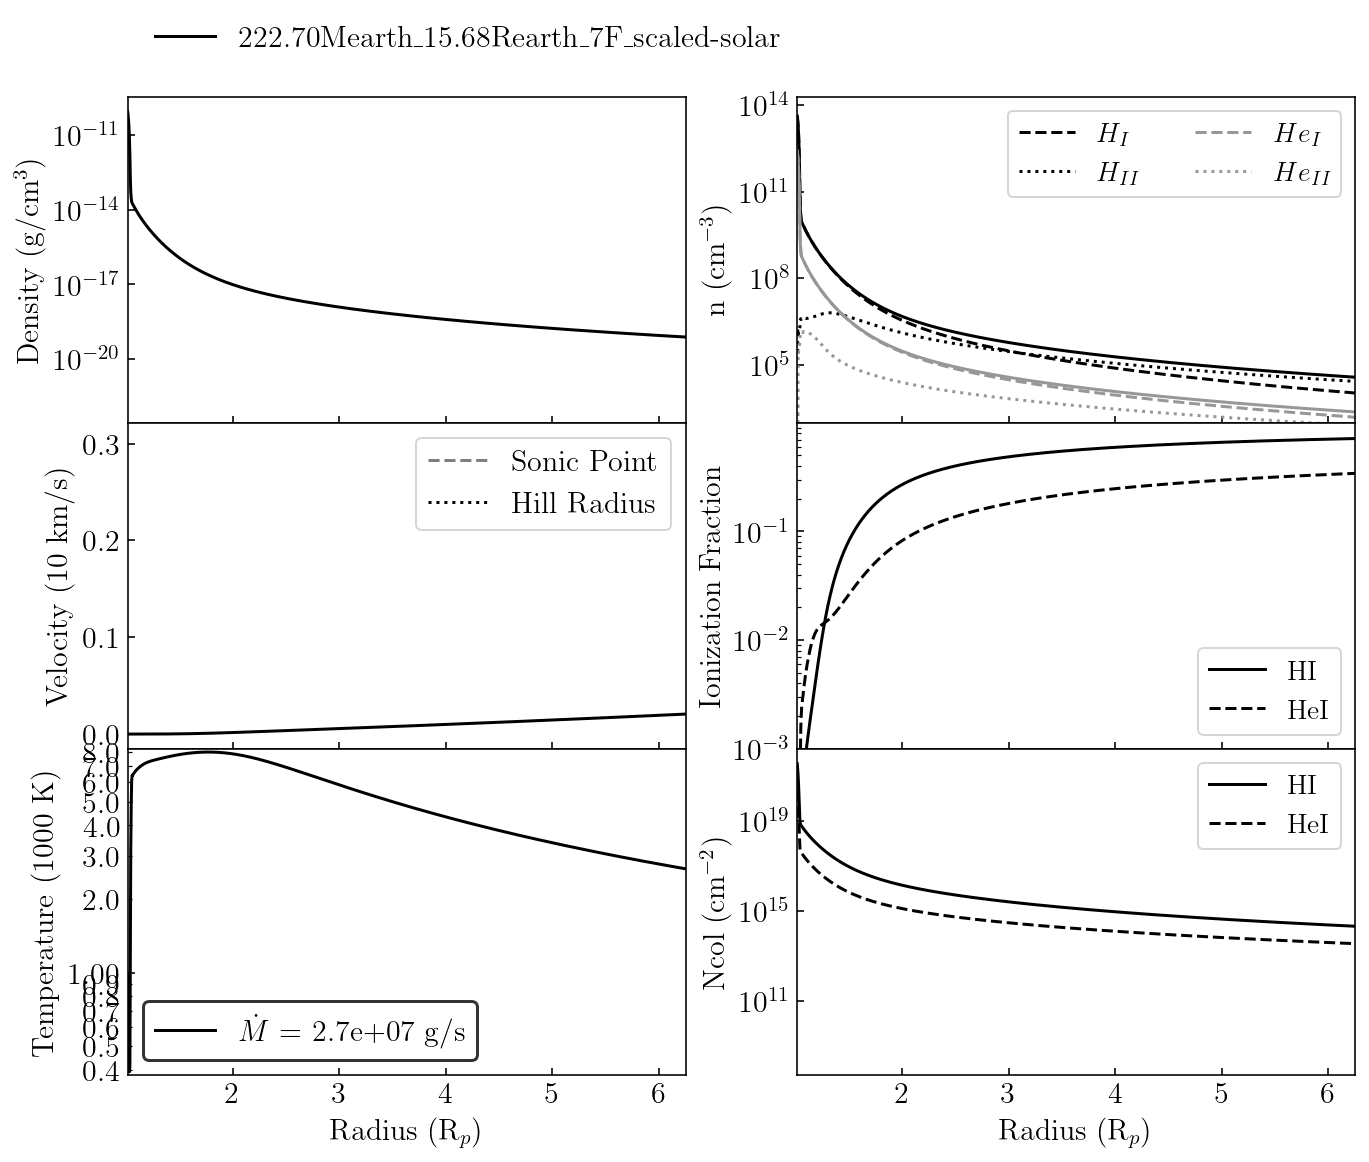

In [45]:
semimajor = np.append(np.array([0.03,0.06]),np.arange(0.1,0.7,0.1))
mdots = np.zeros_like(semimajor)
fluxes = np.zeros_like(semimajor)
for i,a in enumerate(semimajor):
    sim.load_uservars('saves/for_paper/%.2fau.csv'%a)
    print(sim.windsoln.Ftot)
    energy_plot(sim.windsoln)
    plt.show()
    six_panel_plot(sim.windsoln)
    plt.show()
    mdots[i] = sim.windsoln.Mdot
    fluxes[i] = sim.windsoln.Ftot

High gravity compared to sound speed in same temp region.
Could be in core-powered regime (just cite Hilke+James).

- High grav cut off if collisionless at sonic point. 
- Low grav if tau=1 20ev eg is above some NxRp.

Future: Bolometric only wind and then ramp in ionization. 

109571.2977126


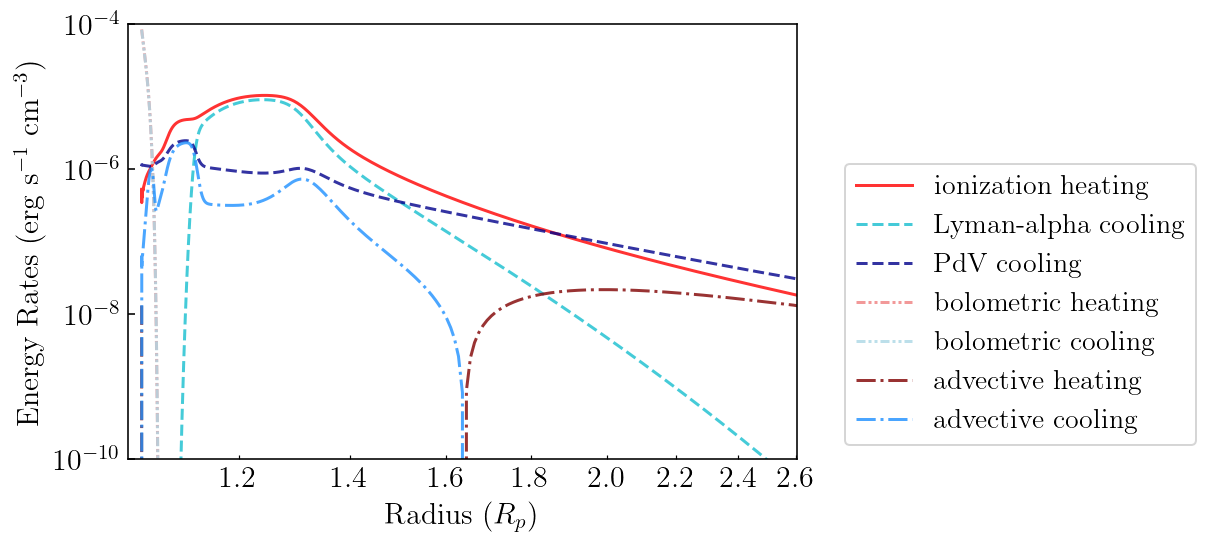

***** 222.70Mearth_15.68Rearth_109571F_scaled-solar: Mdot = 6.64e+11 g/s *****


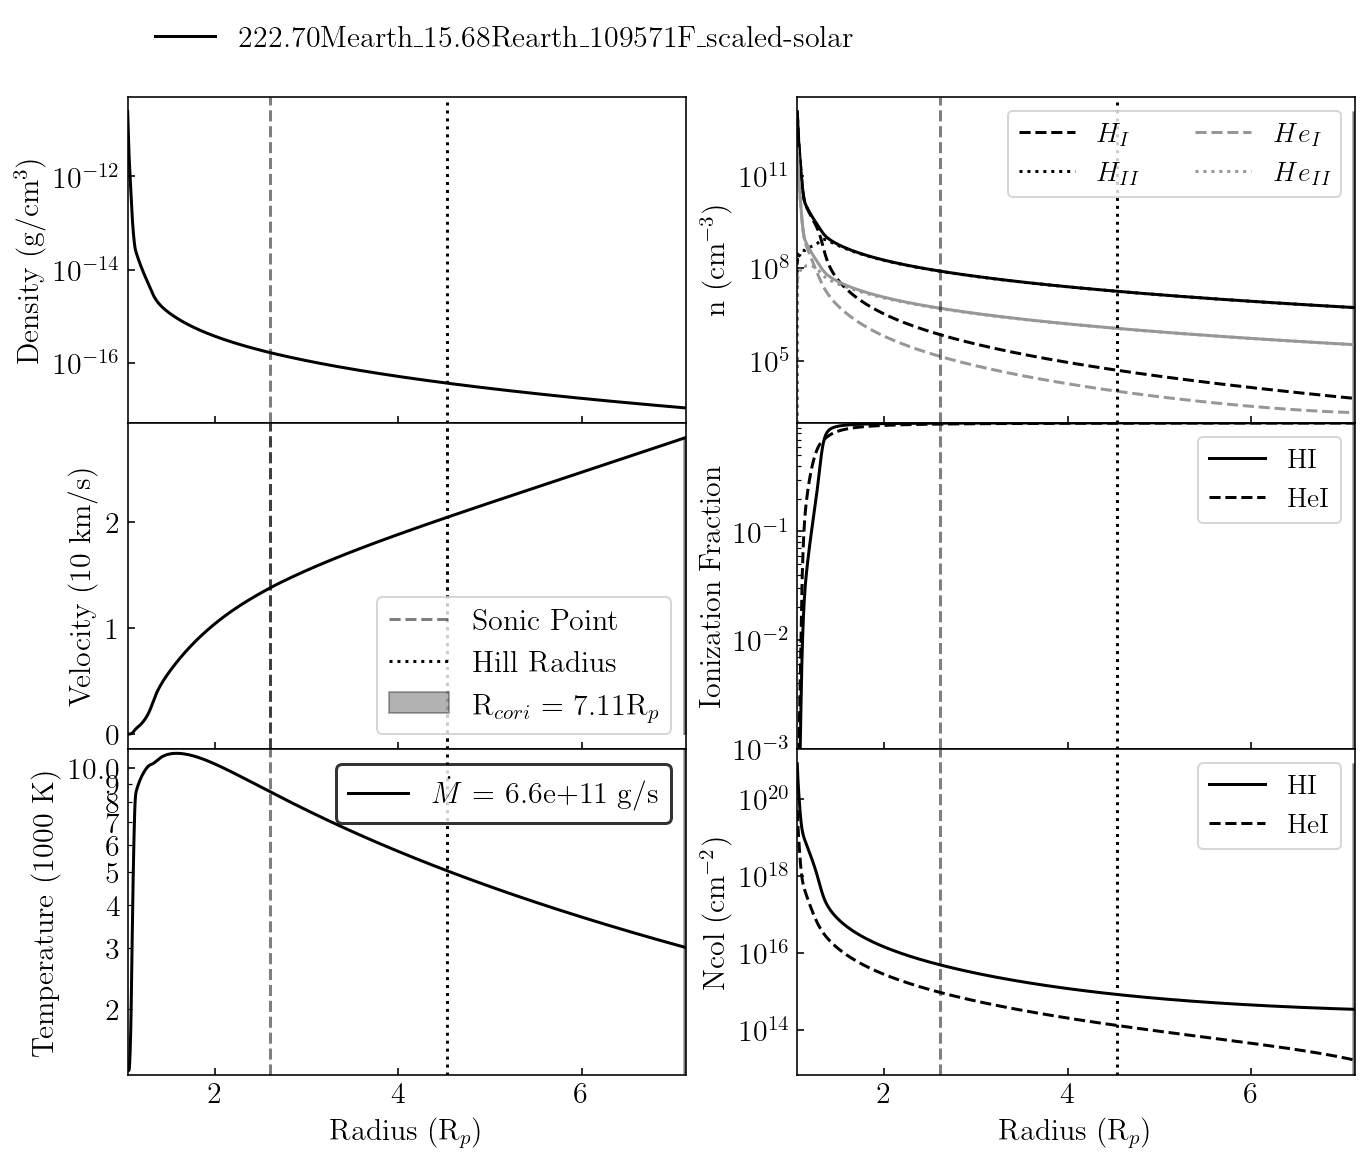

27392.75


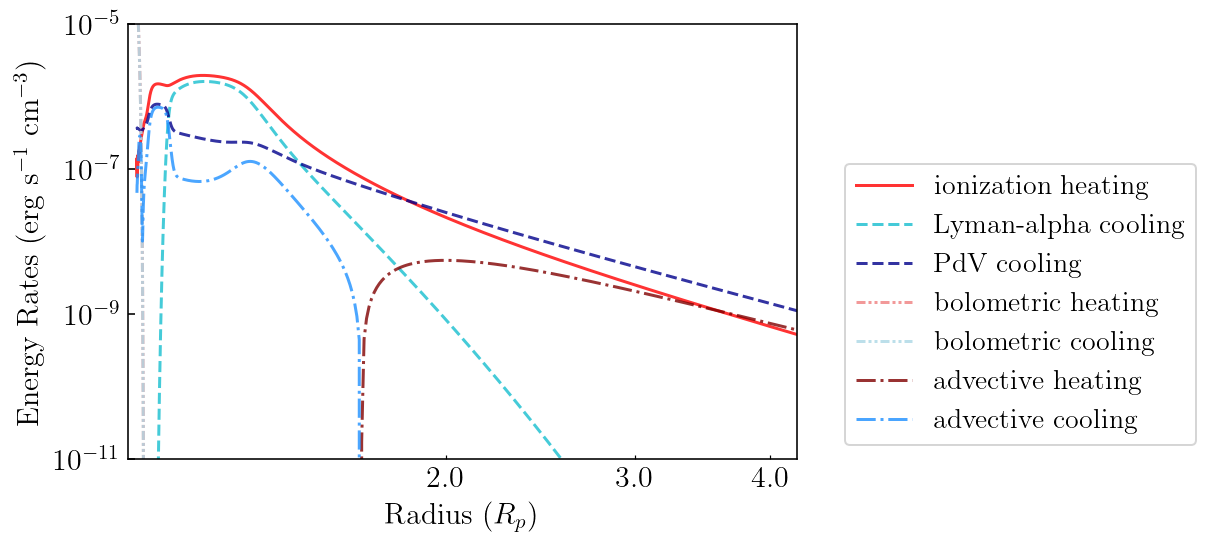

***** 222.70Mearth_15.68Rearth_27392F_scaled-solar: Mdot = 1.98e+11 g/s *****


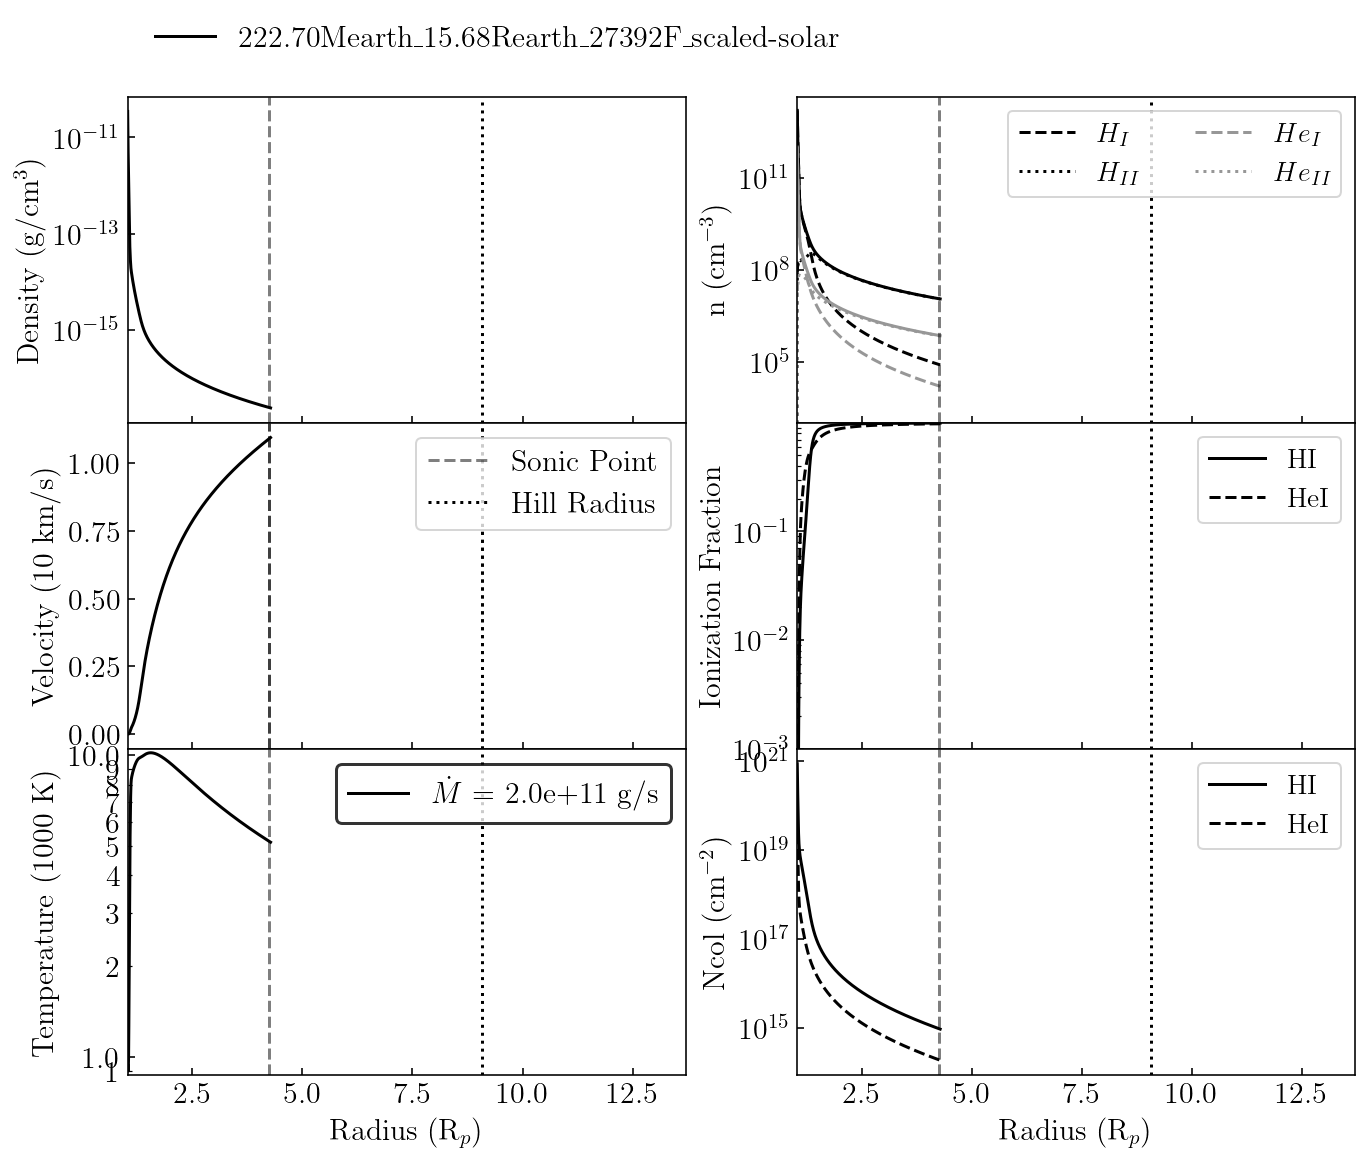

6848.1875


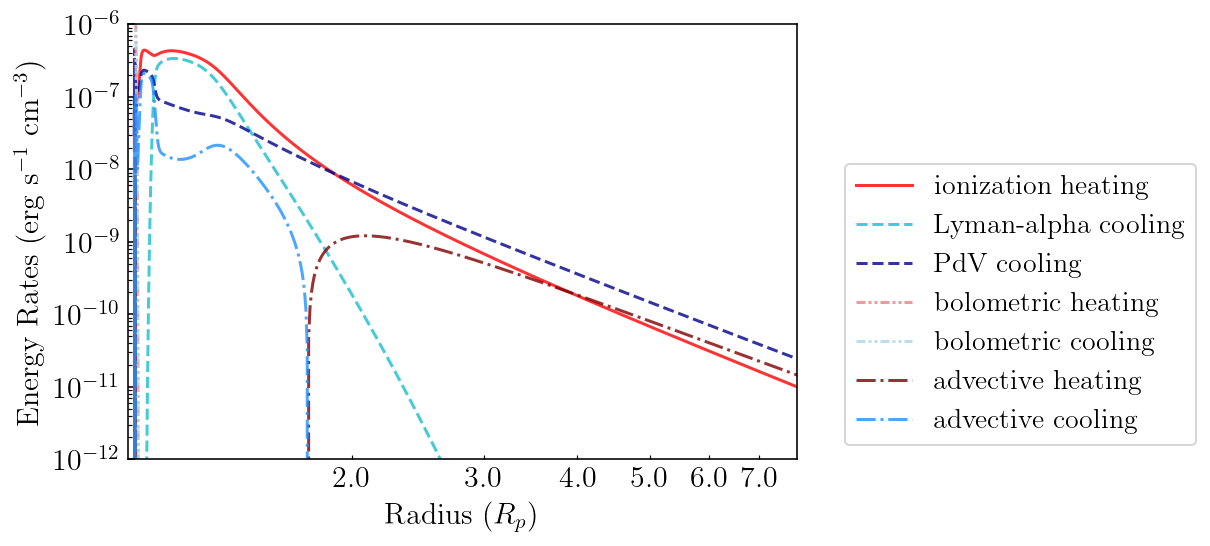

***** 222.70Mearth_15.68Rearth_6848F_scaled-solar: Mdot = 5.42e+10 g/s *****


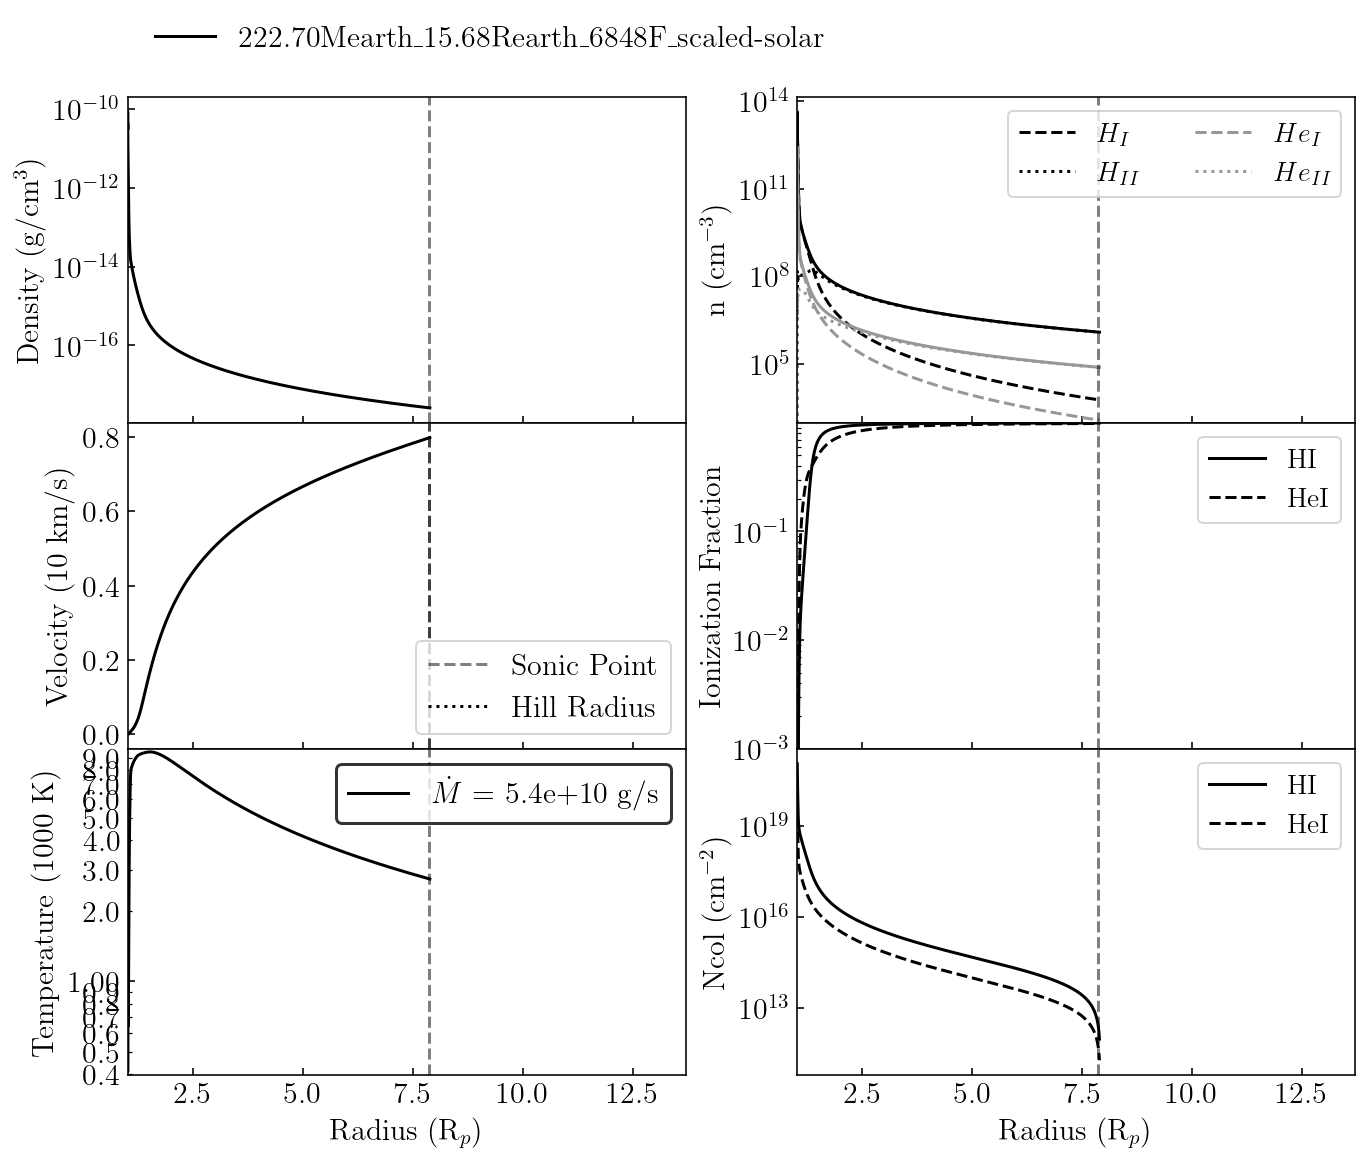

3043.638888889


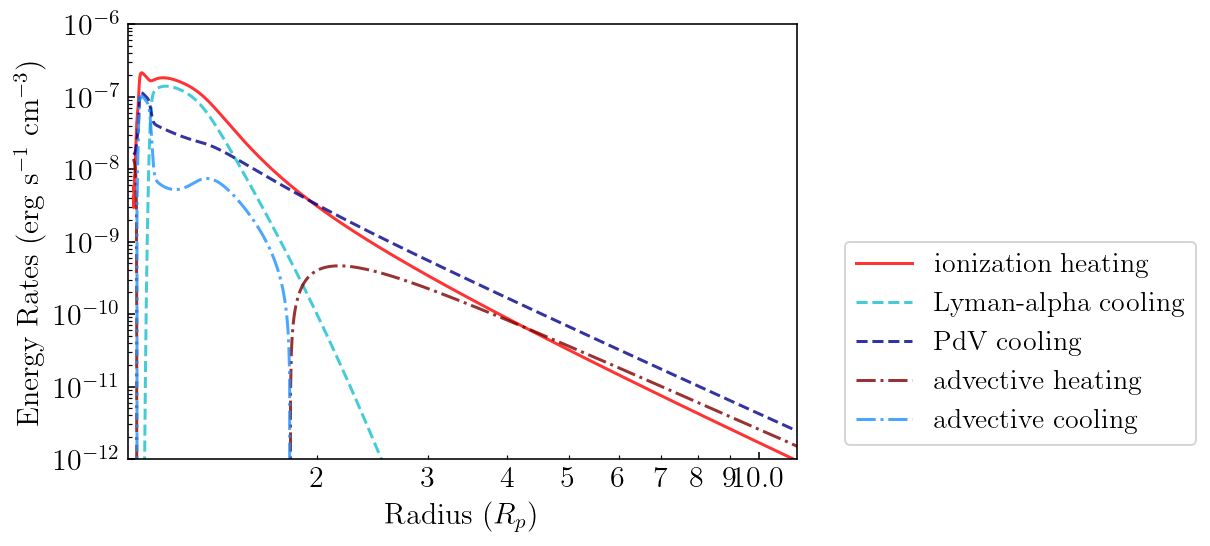

***** 222.70Mearth_15.68Rearth_3043F_scaled-solar: Mdot = 2.55e+10 g/s *****


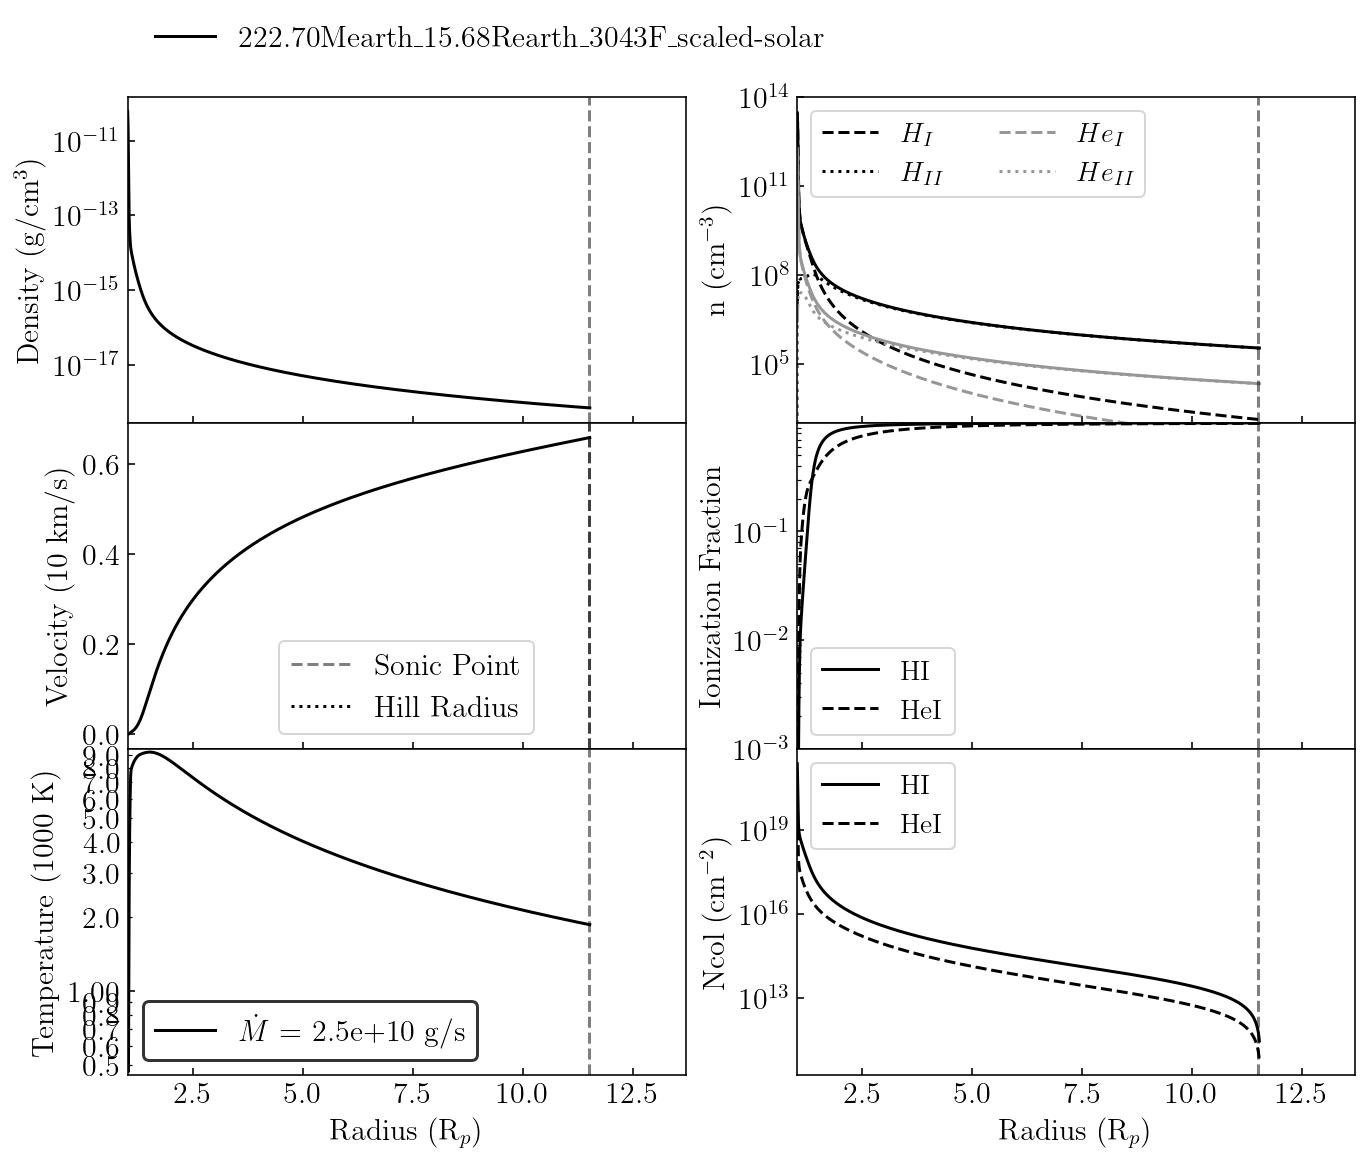

1712.046875


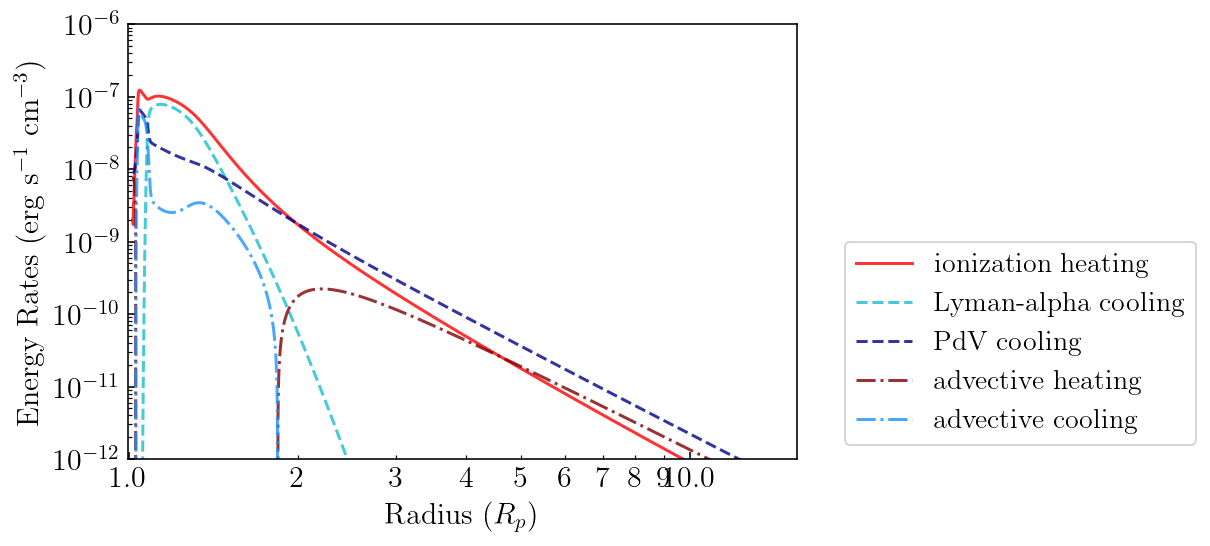

***** 222.70Mearth_15.68Rearth_1712F_scaled-solar: Mdot = 1.38e+10 g/s *****


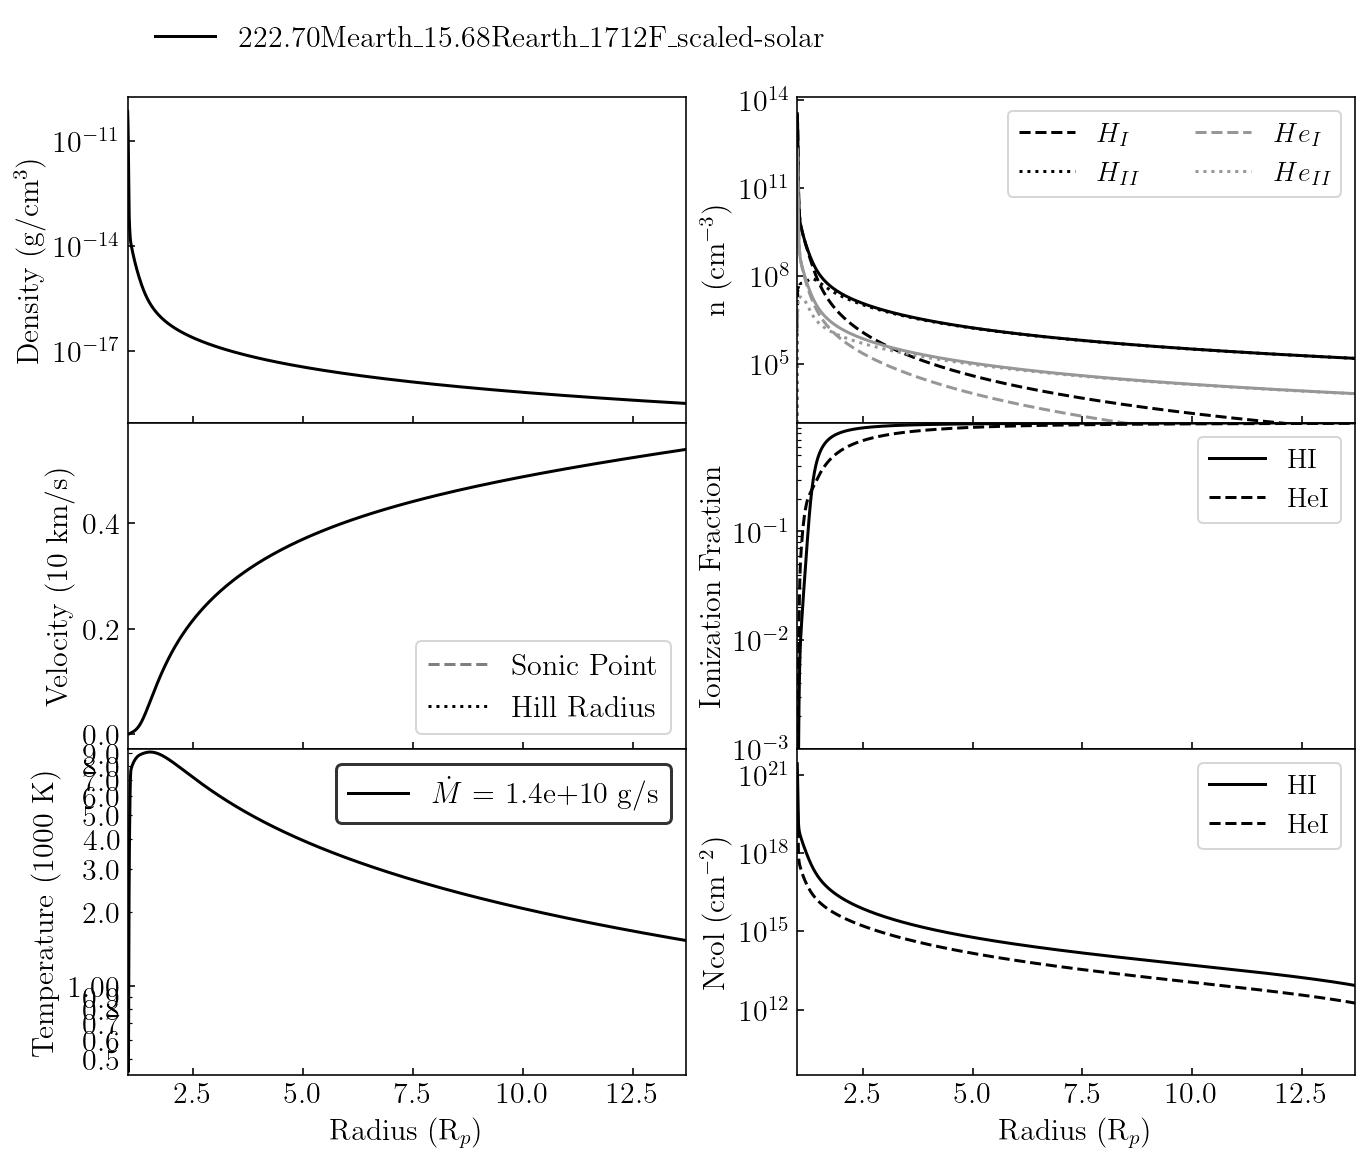

1095.71


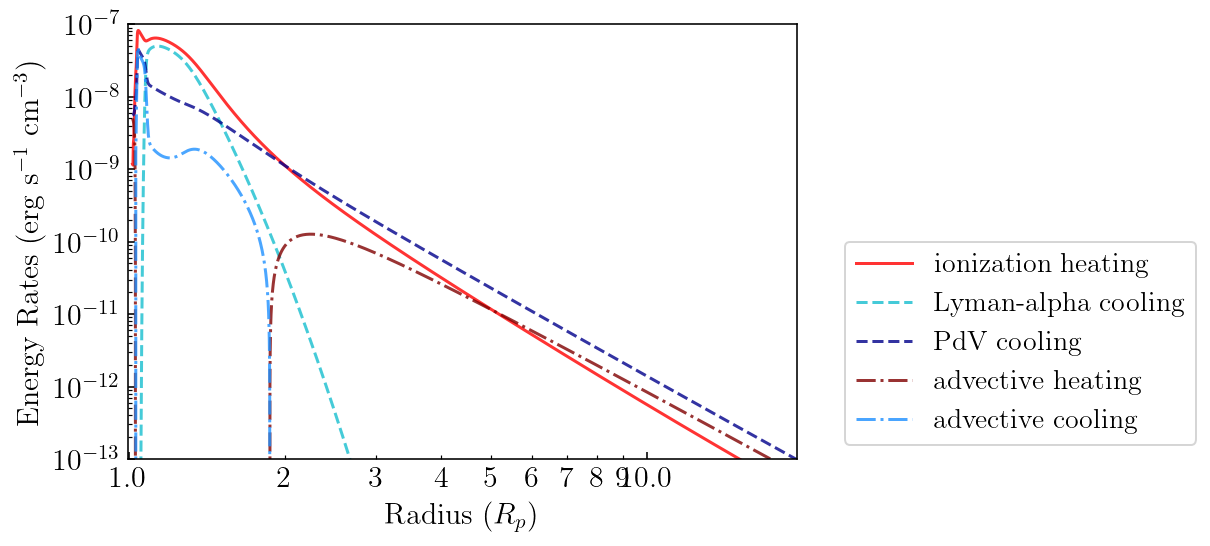

***** 222.70Mearth_15.68Rearth_1095F_scaled-solar: Mdot = 8.71e+09 g/s *****


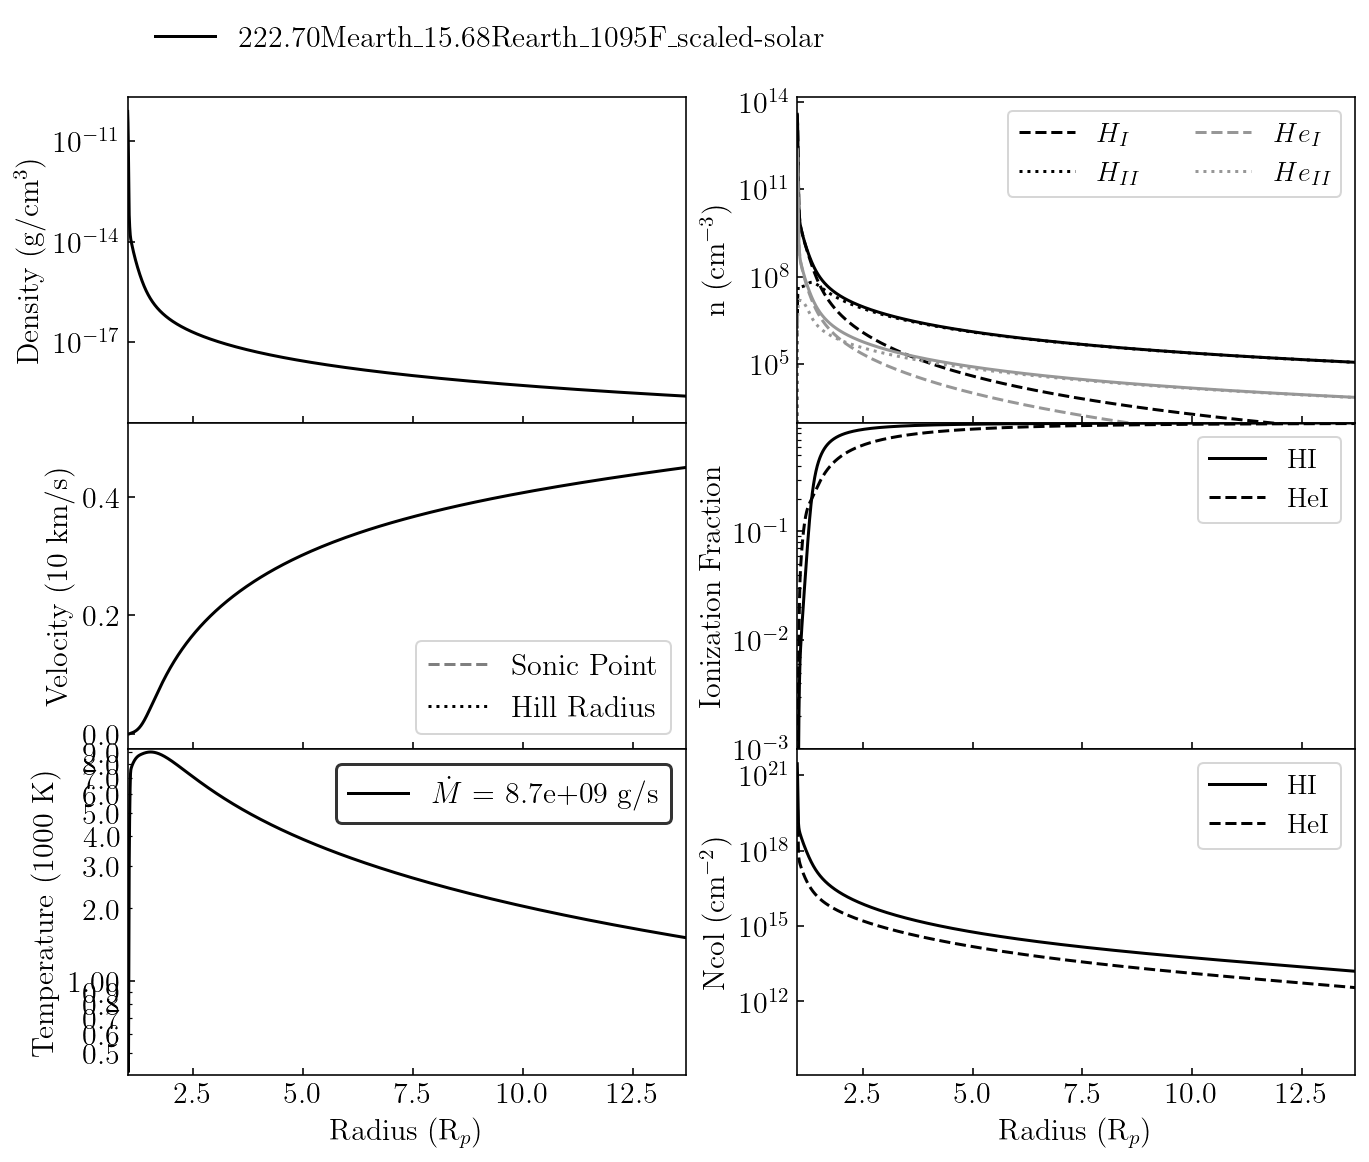

760.9097222222


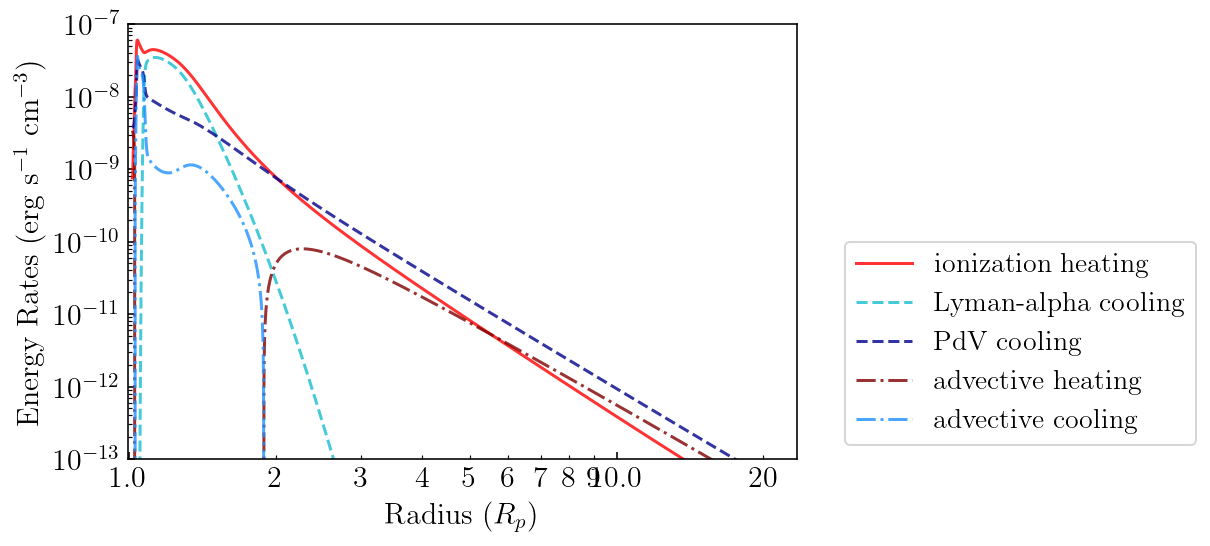

***** 222.70Mearth_15.68Rearth_760F_scaled-solar: Mdot = 5.90e+09 g/s *****


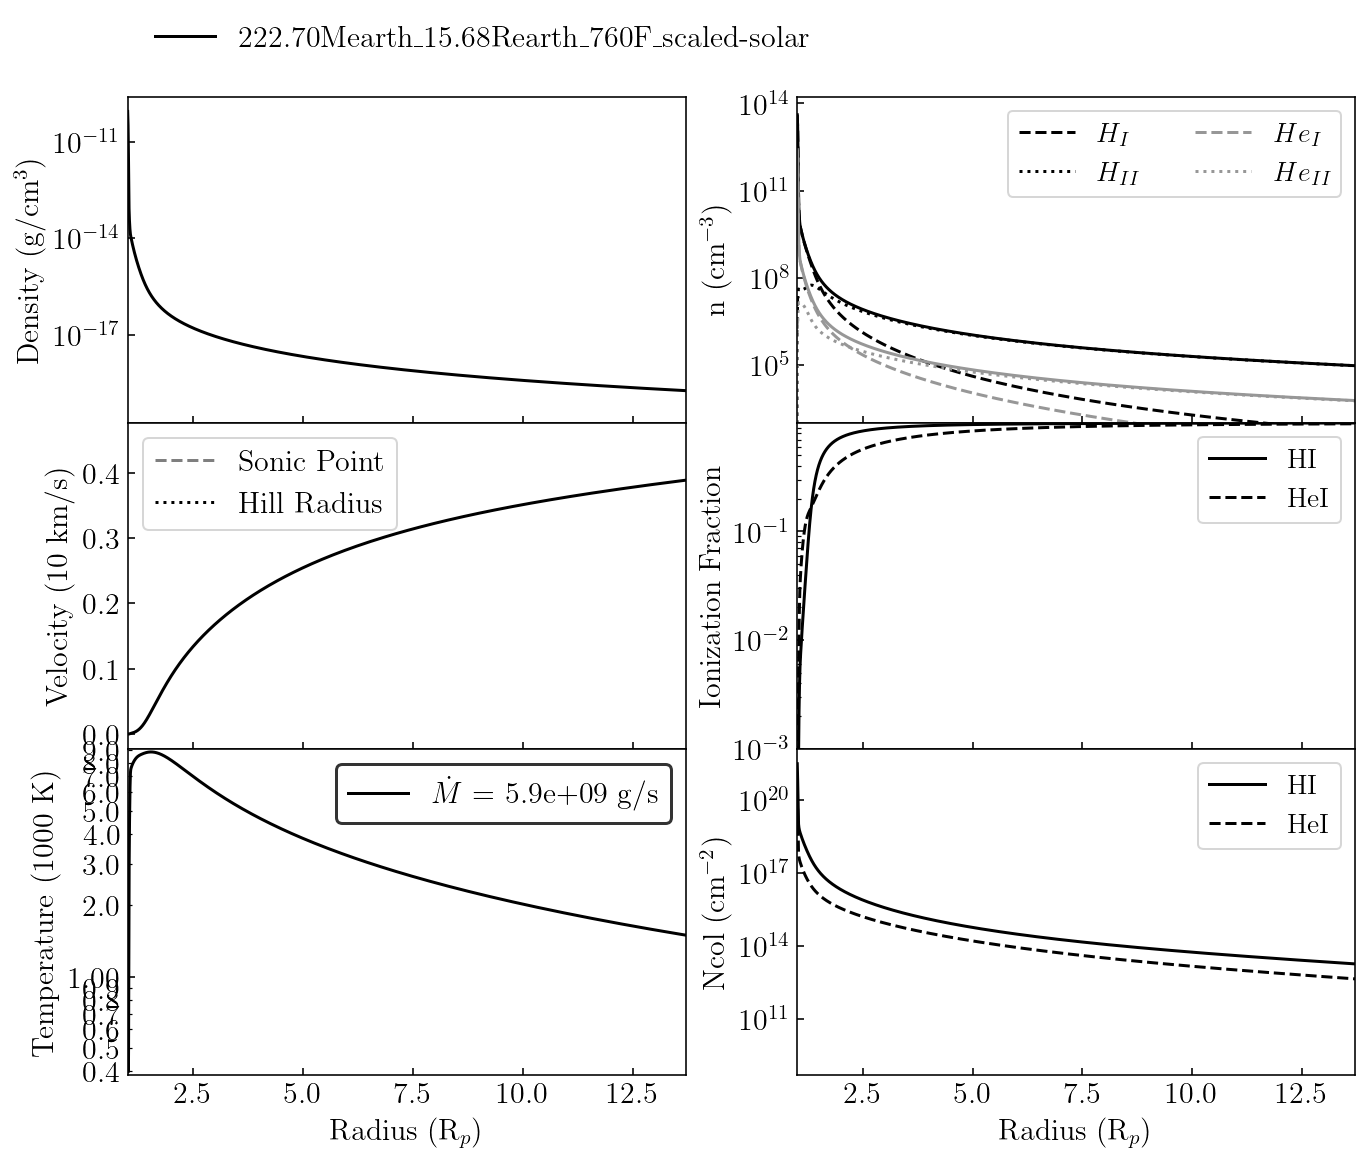

559.0357142857


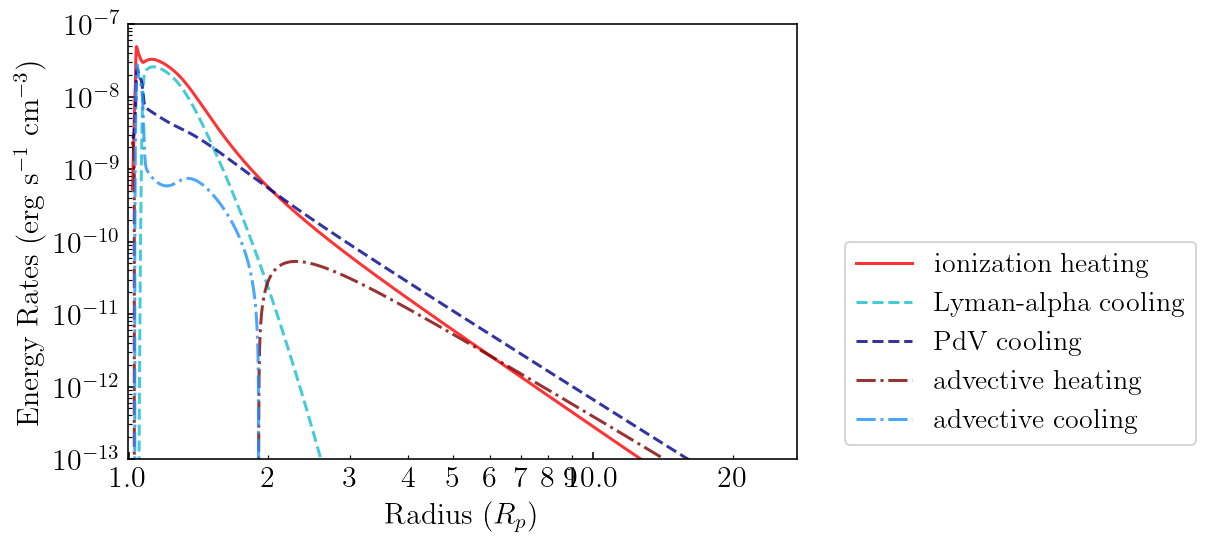

***** 222.70Mearth_15.68Rearth_559F_scaled-solar: Mdot = 4.18e+09 g/s *****


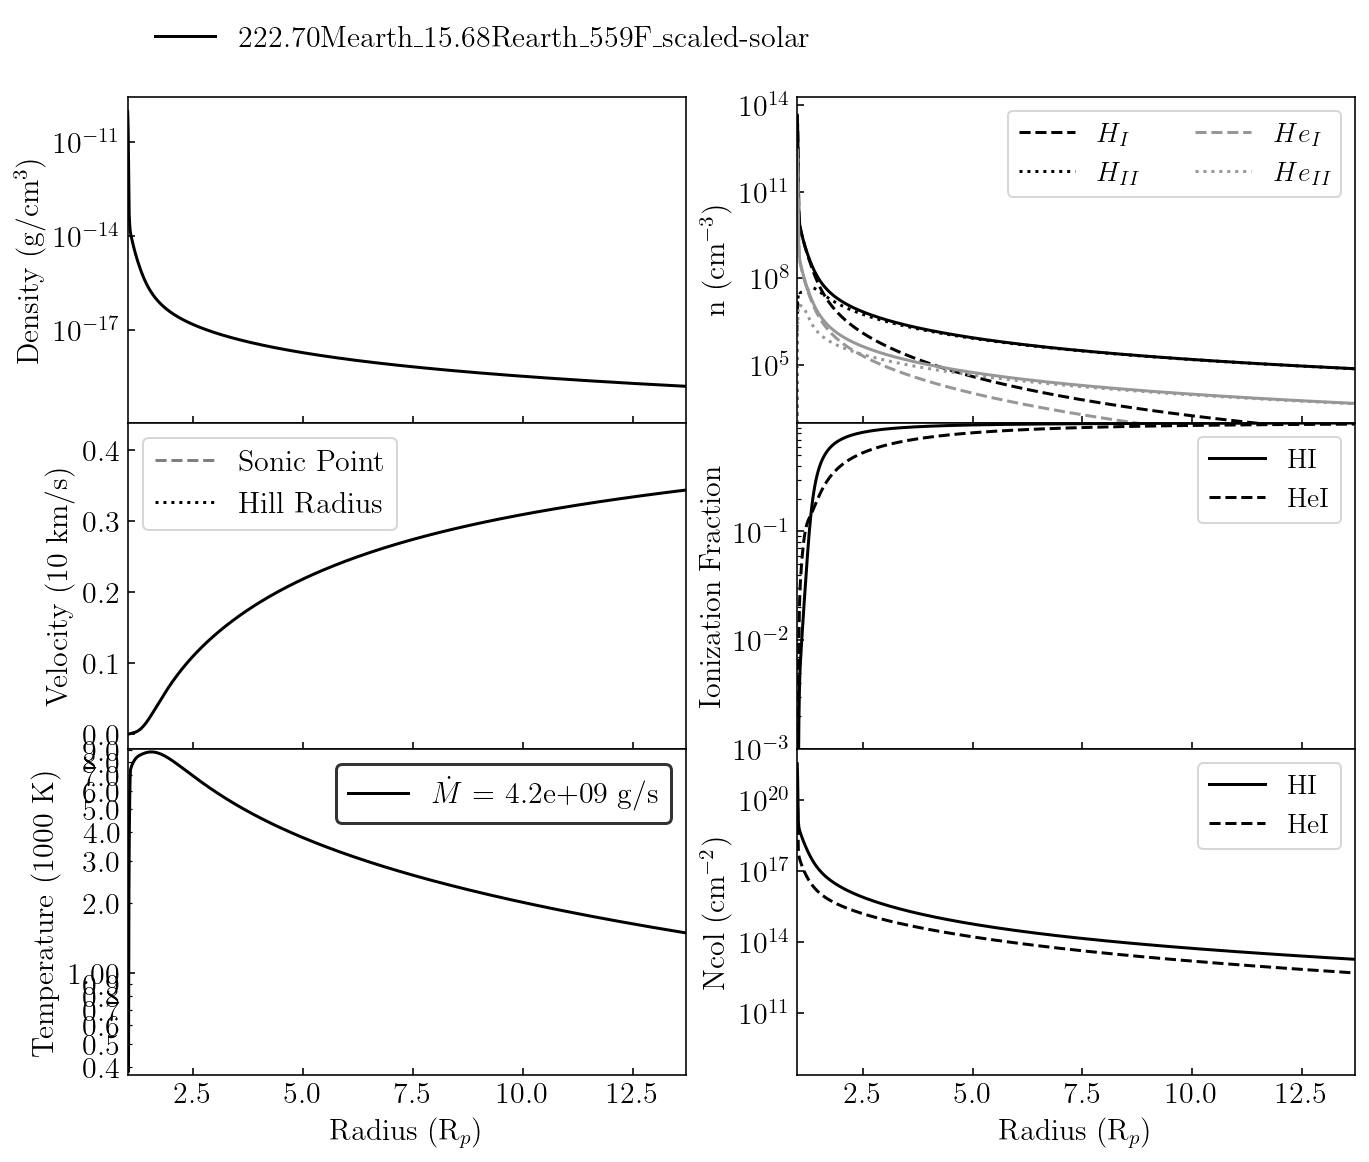

In [46]:
semimajor2 = np.append(0.05,np.arange(0.1,0.8,0.1))
mdots2 = np.zeros_like(semimajor2)
fluxes2 = np.zeros_like(semimajor2)
for i,a in enumerate(semimajor2):
    sim.load_uservars('saves/for_paper/hi_%.2fau.csv'%a)
    print(sim.windsoln.Ftot)
    energy_plot(sim.windsoln)
    plt.show()
    six_panel_plot(sim.windsoln)
    plt.show()
    mdots2[i] = sim.windsoln.Mdot
    fluxes2[i] = sim.windsoln.Ftot

In [ ]:
def erkaev_energy_lim():
    

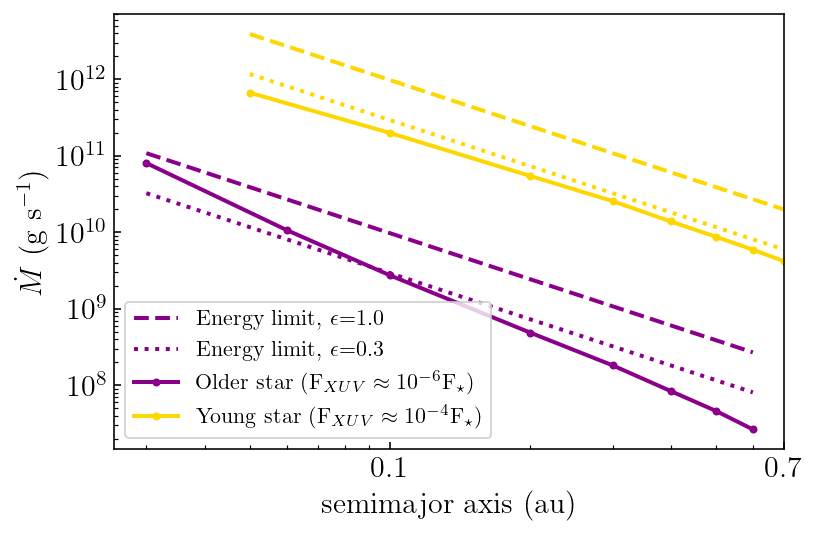

In [47]:
def energy_limit(efficiency,fluxes):
    return efficiency*fluxes*np.pi*sim.windsoln.Rp**3 / (const.G*sim.windsoln.Mp)
plt.plot(semimajor,energy_limit(1,fluxes),c='darkmagenta',lw=2,ls='--',label=r'Energy limit, $\epsilon$=%.1f'%1)
plt.plot(semimajor,energy_limit(0.3,fluxes),c='darkmagenta',lw=2,ls=':',label=r'Energy limit, $\epsilon$=%.1f'%0.3)
plt.plot(semimajor,mdots,marker='.',c='darkmagenta',lw=2,label=r'Older star (F$_{XUV} \approx 10^{-6}$F$_{\star}$)')

plt.plot(semimajor2,energy_limit(1,fluxes2),c='gold',lw=2,ls='--')
plt.plot(semimajor2,energy_limit(0.3,fluxes2),c='gold',lw=2,ls=':')
plt.plot(semimajor2,mdots2,marker='.',c='gold',lw=2,label=r'Young star (F$_{XUV} \approx 10^{-4}$F$_{\star}$)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('semimajor axis (au)')
plt.ylabel(r'$\dot{M}$ (g s$^{-1}$)')
plt.xlim(0,0.7)
plt.xticks([0.1,0.7],labels=['0.1','0.7'])
plt.legend(fontsize=11)
# plt.savefig('../Figures/Final/Mdot_vs_Flux.png',dpi=500,facecolor='white')
plt.show()

Compare to corrected version of energy limited

Talk about tidal potential here

Better colors

PLOT in discussion about low gravity: different opacity ratio (kappa_IR, kappa_opt) - invert as a first start

### 6. Mass Loss Grids <a id='grid'></a>

M vs. R

All planets on three grids with three different fluxes (maybe 1e-4, 1e-5, 1e-6 F_bolo for kicks)

In [4]:
hjs = pd.read_csv('saves/for_paper/new/grids/HJs.dat',delimiter='\t')
# print(hjs['Mass'],hjs['Radius'])
hj_Mp = hjs['Mass']
hj_Rp = hjs['Radius']
# idxs = Mp.argsort()
# sorted_Mp = np.array(Mp[idxs[::1]]*const.Mjupiter/const.Mearth)
# sorted_Rp = np.array(Rp[idxs[::1]]*const.Rjupiter/const.Rearth)
# grav = sorted_Mp/sorted_Rp**2
# sorted_Mp = sorted_Mp[grav<10]
# sorted_Rp = sorted_Rp[grav<10]

# plt.scatter(sorted_Mp,sorted_Rp,c='k')
# hj_M = np.append(np.round(np.linspace(250,1000,10),0),1083)
# hj_R = np.round(np.linspace(10,20,10),0)
# # for M in hj_M:
# #     for R in hj_R:
# #         plt.scatter(M,R,c='y')
# rr = np.linspace(10,20,10)
# mm = 333*np.ones_like(rr)
# plt.scatter(mm,rr,c='y')
# deltaM = abs(hj_M[0]-hj_M[1])
# print(deltaM)
# slopes = hj_R[0]/hj_M
# for i in range(len(hj_M)):
#     s = slopes[i]
#     R=10
#     for M in hj_M:
#         if R < 20:
#             R = M*s+(10-250*s)
#             plt.scatter(M+deltaM*i,R,c='m')

# plt.xlabel('Earth Mass (317 Me / Mjup)')
# plt.ylabel('Earth Radii (11 Re / Rjup)')
# plt.show()

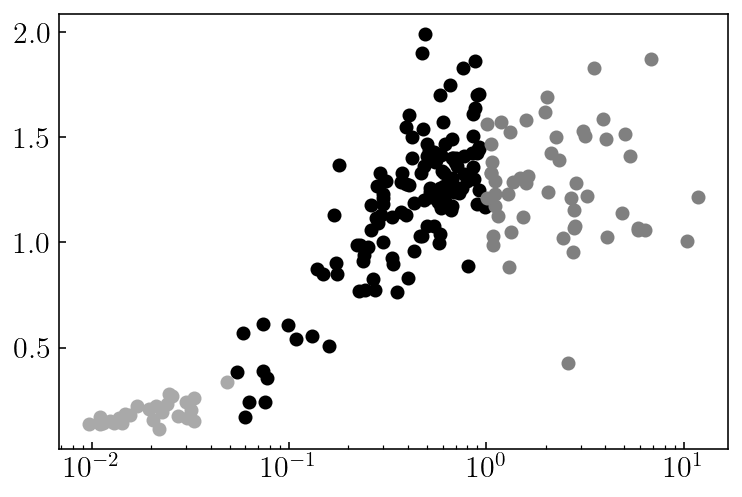

In [7]:
neps = pd.read_csv('saves/for_paper/new/grids/neptunes.csv',
                   delimiter=',')
nep_Mp = neps['mass']
nep_Rp = neps['radius']

sups = pd.read_csv('saves/for_paper/new/grids/superearths.csv',
                   delimiter=',')
sup_Mp = sups['mass']
sup_Rp = sups['radius']

# idxs = Mp.argsort()
# sorted_Mp = np.array(Mp[idxs[::1]]*const.Mjupiter/const.Mearth)
# sorted_Rp = np.array(Rp[idxs[::1]]*const.Rjupiter/const.Rearth)
# grav = sorted_Mp/sorted_Rp**2
# grav1 = grav[np.isnan(grav)==False]

# # print(grav)
# sorted_Mp= sorted_Mp[np.isnan(grav)==False]
# sorted_Rp = sorted_Rp[np.isnan(grav)==False]
# sorted_Mp = np.flip(sorted_Mp)
# sorted_Rp = np.flip(sorted_Rp)
# sorted_Mp = sorted_Mp[25:]
# sorted_Rp = sorted_Rp[25:]


plt.scatter(nep_Mp,nep_Rp,c='k')
plt.scatter(hj_Mp,hj_Rp,c='grey')
plt.scatter(sup_Mp,sup_Rp,c='darkgrey')
plt.xscale('log')
plt.show()


# nep_M = np.round(np.linspace(17,222,10),0)
# nep_R = np.round(np.linspace(3,20,10),0)
# for M in nep_M:
#     for R in nep_R:
#         plt.scatter(M,R)
# plt.show()

In [ ]:
hjs = pd.read_csv('saves/for_paper/new/grids/HJs.dat',delimiter='\t')
# print(hjs['Mass'],hjs['Radius'])
Mp = hjs['Mass']
Rp = hjs['Radius']
idxs = Mp.argsort()
sorted_Mp = np.array(Mp[idxs[::1]]*const.Mjupiter/const.Mearth)
sorted_Rp = np.array(Rp[idxs[::1]]*const.Rjupiter/const.Rearth)
grav = sorted_Mp/sorted_Rp**2
sorted_Mp= sorted_Mp[grav<10]
sorted_Rp = sorted_Rp[grav<10]

plt.scatter(sorted_Mp,sorted_Rp,c='k')
hj_M = np.append(np.round(np.linspace(250,1000,10),0),1083)
hj_R = np.round(np.linspace(10,20,10),0)
# for M in hj_M:
#     for R in hj_R:
#         plt.scatter(M,R,c='y')
rr = np.linspace(10,20,10)
mm = 333*np.ones_like(rr)
plt.scatter(mm,rr,c='y')
deltaM = abs(hj_M[0]-hj_M[1])
print(deltaM)
slopes = hj_R[0]/hj_M
for i in range(len(hj_M)):
    s = slopes[i]
    R=10
    for M in hj_M:
        if R < 20:
            R = M*s+(10-250*s)
            plt.scatter(M+deltaM*i,R,c='m')

plt.xlabel('Earth Mass (317 Me / Mjup)')
plt.ylabel('Earth Radii (11 Re / Rjup)')
plt.show()

##### Ramping through a irregular grid in M/R space
Features:
- Skips ramping to solutions alread has ramped to
- Loads closest solution in M and R before beginning a new 'diagonal' of the grid
- If cannot ramp to first solution in the 'diagonal', then will keep trying with higher radii until a viable solution is reached. After that point, it will then quit after the first failure, assuming that planets thereafter are too massive (revisit this)

In [4]:
path = '../relaxed-wind_good/saves/for_paper/new/full_grids'
f = open(path+'/log_HJ.dat', 'a+')
sim = wind_sim()
# sim.load_planet('saves/for_paper/new/full_grids/222.7Me_15.7Re.csv',
#                print_atmo_composition=False)

last = '250.0Me_10.0Re'
sim.load_planet(path+'/'+last+'.csv')
sim.system.print_system(norm='Earth')

deltaM = abs(hj_M[0]-hj_M[1])
min_R = 10
slopes = min_R/hj_M
for i in range(len(hj_M)):
    s = slopes[i]
    R = min_R    
    M_start = hj_M[i]
    load_closest_planet(M_start,R,path)
    try_new_start = True
    for M in hj_M:
        R = M*s+(min_R-min(hj_M)*s)
        M += deltaM*i
        if R > 20:
            break
        skip = False
#         first_success = True
        if try_new_start == True:
            load_closest_planet(M,R,path)
        print(f"----\nM = {M:.1f}, R = {R:.1f}\n")
        fname = f"{np.round(M,0):.1f}Me_{np.round(R,0):.1f}Re"
        #check if file exist, skip if it does
        dir_list = os.listdir(path)
        for file in dir_list:
            if file.split('Re')[0] == fname.split('Re')[0]:
                skip = True
        if skip == True:
            continue
            
        temp = system(M*const.Mearth,R*const.Rearth,
                      *sim.windsoln.planet_tuple[2:])
        result = sim.ramp_grav(temp,make_plot=False,
                               integrate_out=False,
                               expedite=True,
                               converge=False)
        energy_plot(sim.windsoln)
        plt.title(f"M = {M:.1f}, R = {R:.1f}")
        plt.show()
        plt.close()

        if result == 0:
            try_new_start = False
            polish = sim.polish_bcs(converge_Rmax=False)
            if polish == 5:
                sim.save_planet(f'{path:s}/{fname:s}_5.csv',
                                overwrite=True)
#                 if first_success==True:
#                     last = fname+'_5'
            elif polish == 0:
                sim.save_planet(f'{path:s}/{fname:s}.csv',
                                overwrite=True)
#                 if first_success==True:
#                     last = fname
            else:
                sim.save_planet(f'{path:s}/{fname:s}_idk.csv',
                                overwrite=True)
#                 if first_success==True:
#                     last = fname+'_idk'
#             first_success = False
        else:
#             f.write(f'{M:.1f},{R:.1f}\n')
            if try_new_start == True:
                print(f'Failed at {M:.1f} Mearth, {R:.1f} Rearth. Continuing...')
            else:
                print(f'Failed at {M:.1f} Mearth, {R:.1f} Rearth. Stopping here.')
                break

    #     sim.load_planet(f'{path:s}/{last:s}.csv',
    #                     print_atmo_composition=False)

Atmosphere Composition
  Species:   HI,        HeI
  Mass frac: 8.00e-01, 2.00e-01
Loaded Planet:
  System parameters (cgs)               # Normalized units
    Mp:        1.330000e+30 g           #   222.70 ME
    Rp:        1.000000e+10 cm          #    15.68 RE
    Mstar:     1.988416e+33 g           #     1.00 Msun
    semimajor: 7.480000e+11 cm          #     0.05 au
    Ftot:      1.095713e+03 erg/cm^2/s  # 2.35e+02 FuvEarth
    Lstar:     3.828000e+33 erg/s       # 1.00e+00 Lsun



### 7. James <a id='james'></a>

In [2]:
sim = wind_sim()
sim = wind_sim()
sim.load_planet('saves/windsoln.csv',expedite=False)
james = system(1.89852340000000002e+30,55*const.Rearth,
               1.98841600000000008e+33,7.48000000000000000e+11,
               5.36436000000000000e+05,3.84599999999999995e+33)
# sim.load_planet('saves/for_paper/new/HD209_13.6-2000eV_H-He.csv',expedite=False)
sim.ramp_to(james,converge=False)
# print(sim.windsoln.bcs_tuple)

Atmosphere Composition
  Species:   HI,        HeI
  Mass frac: 8.00e-01, 2.00e-01
Ramping Ftot from 5.364e+05 to 5.364e+05.                                                     
  Ftot already done.                                                 
Ramping Mp from 1.899e+30 to 1.899e+30 AND Rp from 1.831e+10 to 3.508e+10.
  Mp already done.
  Trying: Rp:2.424438e+10, M_delta:0.0025                                               ...Intermediate Ramping BCs activated.
Attempting to ramp Rmin:1.04->1.07Rp, rho:2.463e-11->2.463e-11g/cm3, T:1331->1331K                                                                                                                                                ..Initial jump failed. Ramping variables individually.
   Successfully converged Rmin to 1.072625 Rp.992Rp. Trying 1.0726249                                                                                                       
  Trying: Rp:2.427469e+10, M_delta:0.0025                                    

KeyboardInterrupt: 

In [9]:
# sim.load_planet('saves/windsoln.csv')
print(sim.windsoln.flags_tuple)
sim.inputs.write_flags(1,1,0.1,0)
sim.run_wind()

[1, 1, 0.0, 0]


1

In [11]:
print(sim.erf_velocity())
print(sim.windsoln.erf_drop)

(0.0006429009245407308, 0.0001854488369862039)
[0.00037428 0.00029342]


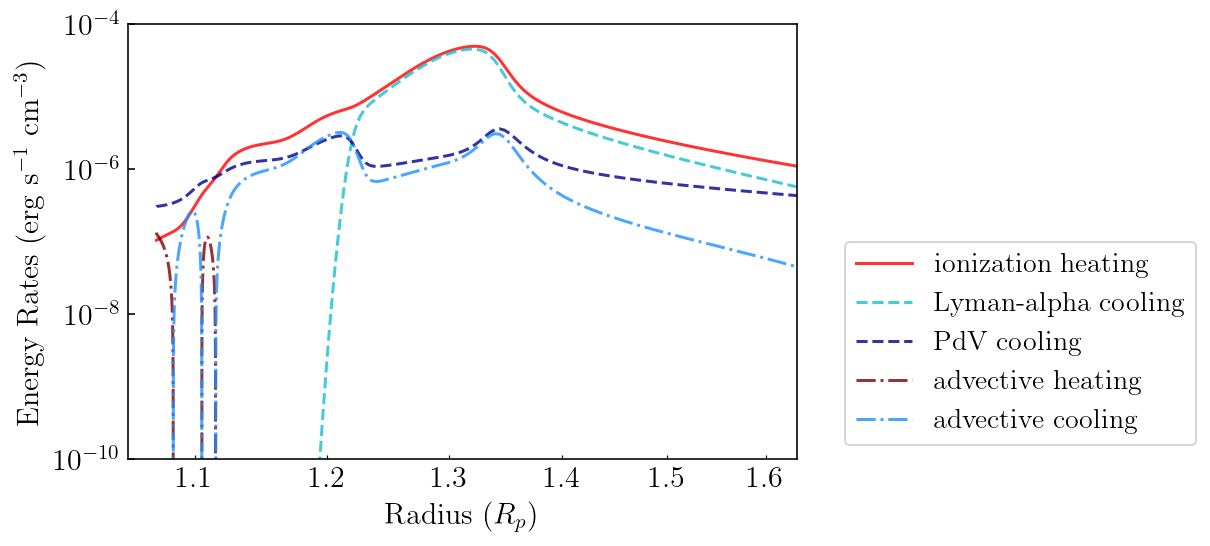

In [3]:
energy_plot(sim.windsoln)

In [21]:
sim.windsoln.rho_rmin

24634.73214267

In [20]:
sim.polish_bcs()

Polishing up boundary conditions...
Successfully ramped base boundary conditions.                                                                                                                                                                         ..Turning off bolometric heating/cooling.
NOTE: Photoionization heating dominates down to base of sim (1.042 Rp). 
   Bolometric heat/cooling still turned off. Max error in dM/dt ~ 10%. 
 See documentation for workaround.
..Rmax 1.0141e+01, r_Cori 6.7611e+00                                                                                                                                                     Rmax done, but Ncol cannot be lowered to self-consistent value without introducing integration errors. Maximum error in Mdot in this case is 10 percent.
Failed to polish setting Rmax to R_coriolis (converge_Rmax).



5

In [24]:
'%.2e'%sim.windsoln.Mdot

'2.28e+12'

In [42]:
r_temp,temp = (np.genfromtxt('Data_for_Comparisons/temperature_19Me.csv',delimiter=', ').T)
r_dens,dens = (np.genfromtxt('Data_for_Comparisons/density_19Me.csv',delimiter=', ').T)
data = (np.genfromtxt('Data_for_Comparisons/velocity_unsorted_19Me.csv',delimiter=', '))
data_sorted = data[data[:,0].argsort()]
r_vel,vel = data_sorted.T
new_r = (r_temp[0]+r_dens[0]+r_vel[0])/3/sim.windsoln.Rp
new_r = 1.19
new_rho = 1e-14
new_T = temp[0]/sim.windsoln.scales_dict['T']
print(new_r)
print(new_rho)
print(new_T)
print(sim.windsoln.bcs_tuple[0:4])

1.1388630972303941
1974.4882128159506
0.09994787585865832
[1.041660533925, 6.794886101878, 24634.73214267, 0.133065169987]


In [22]:
sim.save_planet('saves/for_paper/new/james_H-He_13.6-2000eV.csv',overwrite=True)

Saving saves/for_paper/new/james_H-He_13.6-2000eV.csv


In [2]:
sim.ramp_Rmin(new_r)

NameError: name 'new_r' is not defined

In [22]:
sim.ramp_rho_rmin(new_rho)

   Successfully converged rho_rmin to 1.974e+03                                                                                          

0

In [19]:
sim.ramp_T_rmin(new_T)

   Successfully converged T_rmin to 0.0999                                                       

0

In [28]:
sim.windsoln.add_user_vars()

Atmosphere Composition
  Species:   HI,        HeI
  Mass frac: 8.00e-01, 2.00e-01


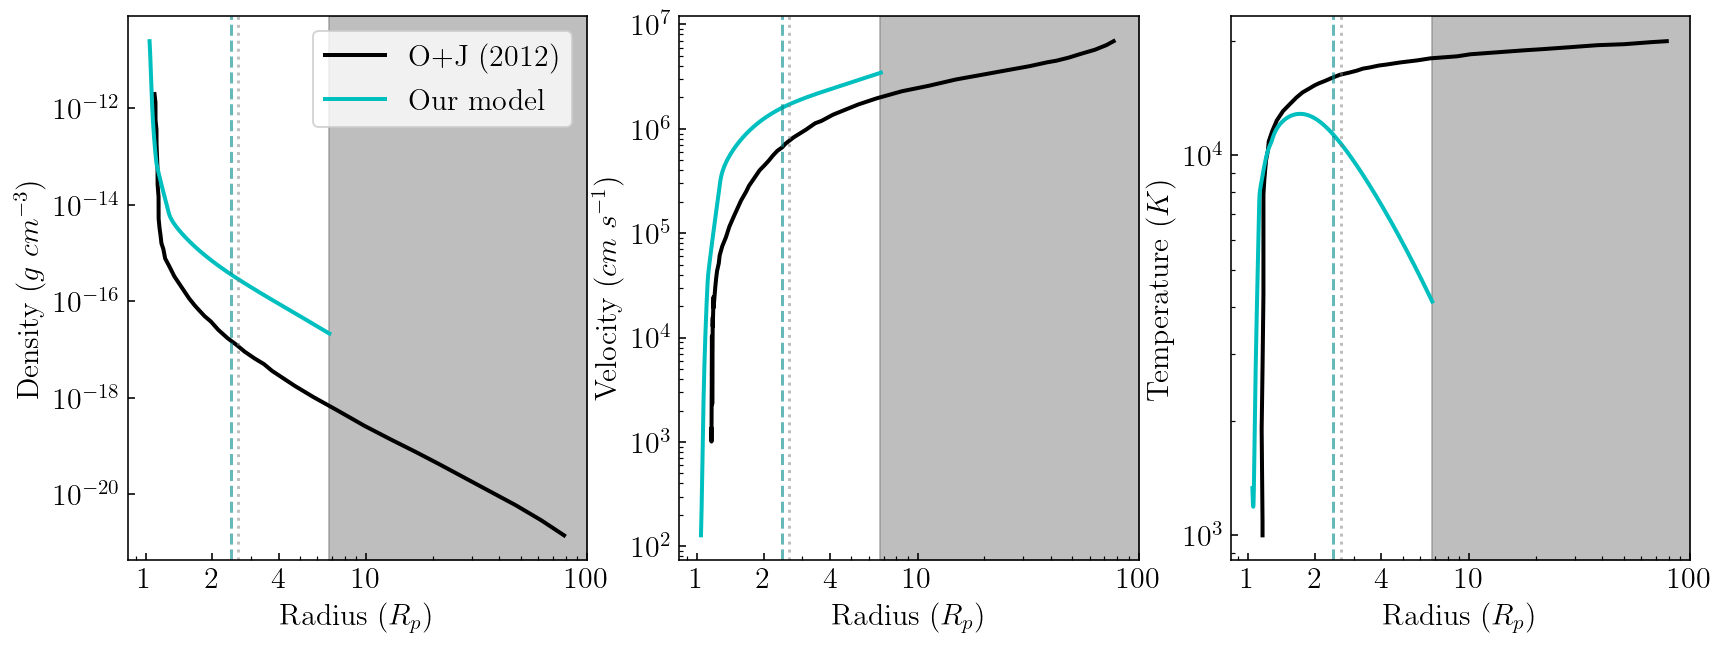

In [30]:
sim = wind_sim()
sim.load_planet('saves/for_paper/new/james_H-He_13.6-2000eV.csv',expedite=False)
r_temp,temp = (np.genfromtxt('Data_for_Comparisons/temperature_19Me.csv',delimiter=', ').T)
r_dens,dens = (np.genfromtxt('Data_for_Comparisons/density_19Me.csv',delimiter=', ').T)
data = (np.genfromtxt('Data_for_Comparisons/velocity_unsorted_19Me.csv',delimiter=', '))
data_sorted = data[data[:,0].argsort()]
r_vel,vel = data_sorted.T

r = sim.windsoln.soln_norm['r']
fig,ax = plt.subplots(1,3,figsize=(14,5))
ax[2].loglog(r_temp/sim.windsoln.Rp,temp,lw=2,c='k')
ax[2].loglog(r,sim.windsoln.soln['T'],c='c',lw=2)
lims = np.copy(ax[2].get_ylim())
ax[2].fill_betweenx(lims,sim.windsoln.r_cori,100,
                   color='tab:gray',alpha=0.5)
ax[2].set_ylim(lims)
ax[2].set_ylabel('Temperature ($K$)')

ax[0].loglog(r_dens/sim.windsoln.Rp,dens,lw=2,c='k',label=r'O+J (2012)')
ax[0].loglog(r,sim.windsoln.soln['rho'],c='c',lw=2,label='Our model')
lims = np.copy(ax[0].get_ylim())
ax[0].fill_betweenx(lims,sim.windsoln.r_cori,100,
                   color='tab:gray',alpha=0.5)
ax[0].set_ylim(lims)
ax[0].set_ylabel('Density ($g$ $cm^{-3}$)')
ax[0].legend()

ax[1].loglog(r_vel/sim.windsoln.Rp,vel,lw=2,c='k')
ax[1].loglog(r,sim.windsoln.soln['v'],c='c',lw=2)
lims = np.copy(ax[1].get_ylim())
ax[1].fill_betweenx(lims,sim.windsoln.r_cori,100,
                   color='tab:gray',alpha=0.5)
ax[1].set_ylim(lims)
ax[1].set_ylabel('Velocity ($cm$ $s^{-1}$)')
for i in range(3):
    ax[i].set_xlim(right=100)
    ax[i].set_xticks([1,2,4,10,100],labels=['1','2','4','10','100'])
    ax[i].set_xlabel('Radius ($R_p$)')
    ax[i].axvline(3.3e10/sim.windsoln.Rp,c='tab:gray',ls=':',alpha=0.5)
    ax[i].axvline(sim.windsoln.R_sp,c='darkcyan',ls='--',alpha=0.6)
#     ax[i].fill_betweenx((0,1e8),sim.windsoln.r_cori,sim.windsoln.Rmax,
#                        color='tab:gray',alpha=0.5)
# plt.savefig('../Figures/final_james_plot.pdf',dpi=500,facecolor='white',
#             bbox_inches='tight')
plt.show()

In [10]:
from scipy.interpolate import CubicSpline

In [18]:
v_new = []
r_vnew = []
for i in range(len(vel)-1):
    if vel[i+1]>vel[i]:
        v_new = np.append(v_new,vel[i])
        r_vnew = np.append(r_vnew,r_vel[i])
        
T_new = []
r_Tnew = []
for i in range(len(temp)-1):
    if temp[i+1]>=temp[i]:
        T_new = np.append(T_new,temp[i])
        r_Tnew = np.append(r_Tnew,r_temp[i])  

In [22]:
idxs = np.argsort(r_temp)
r_Tnew = r_temp[idxs]
T_new = temp[idxs]

idxs = np.argsort(r_vel)
r_vnew = r_vel[idxs]
v_new = vel[idxs]

In [41]:
print(r_Tnew/(19*const.Rearth))

[ 1.19541411  1.20654222  1.20654222  1.20654222  1.21777392  1.21777392
  1.21777392  1.22911017  1.24055195  1.25210025  1.27552035  1.28739417
  1.3360051   1.39935802  1.4931308   1.6080184   1.71577378  1.83074999
  1.97161539  2.08433283  2.1831712   2.30798331  2.48556899  2.70173735
  2.96404351  3.22182449  3.4377231   3.66808936  4.06167809  4.41491965
  5.07323497  6.04983778  6.9519382   7.98855217  9.17973721 10.54854165
 14.0585624  18.73654039 22.13726742 29.7780769  39.68671369 52.40460891
 69.19804587 81.75765717]


In [39]:
print(dens)

[1.97448821e-12 1.33352143e-12 9.00628020e-13 5.69746700e-13
 3.60427718e-13 1.87381742e-13 5.40697729e-14 2.63302235e-14
 1.46141220e-14 5.13129842e-15 3.24611302e-15 2.34055139e-15
 1.58075162e-15 1.21682262e-15 7.69774706e-16 5.55032203e-16
 3.28886051e-16 2.22121659e-16 1.60156826e-16 1.15478198e-16
 8.32634775e-17 6.84269642e-17 4.93380315e-17 3.79791687e-17
 2.56502091e-17 1.73235288e-17 1.24908188e-17 9.00628020e-18
 6.49381632e-18 4.99877554e-18 3.60427718e-18 1.75516594e-18
 1.04002901e-18 5.40697729e-19 2.63302235e-19 1.36887451e-19
 7.59769435e-20 4.21696503e-20 1.13977252e-20 5.92553098e-21
 2.88554115e-21 1.40516483e-21]


In [23]:
# print(dens)
idx = len(dens)-np.searchsorted(np.flip(dens),1e-14)
print(r_dens[idx]/(19*const.Rearth))
t = CubicSpline(r_Tnew,T_new)
v = CubicSpline(r_vnew,v_new)
print(t(r_dens[idx]))
print(v(r_dens[idx]))

1.193479601988479


ValueError: `x` must be strictly increasing sequence.